# **Feature engineering Notebook**

## Objectives

* Engineer features for Classification

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Generate a list with variebles to use in model



---

# Set up the Working Directory

Define and confirm the working directory.

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/workspaces/heart-disease-analysis-and-prediction'

# Load data

Loading train set

In [2]:
import pandas as pd

train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   42    1   3       148   244    0        0      178      0      0.8      2   
1   66    0   2       146   278    0        0      152      0      0.0      1   
2   53    1   2       130   246    1        0      173      0      0.0      2   

   ca  thal  
0   2     2  
1   1     2  
2   3     2

Loading test set

In [3]:
test_set_path = "outputs/datasets/cleaned/TestSetCleaned.csv"
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   44    1   2       130   233    0        1      179      1      0.4      2   
1   58    0   1       136   319    1        0      152      0      0.0      2   
2   63    1   0       140   187    0        0      144      1      4.0      2   

   ca  thal  
0   0     2  
1   2     2  
2   2     3

The data has already been check and cleaned , ready for feature engineering step.

---

# Custom function for feature engineering


Feature engineering is a crucial step in the data preprocessing process, and it can significantly impact the performance of the machine learning models
We are going to use the custom function from the Code Institute walkthrough project 'Churnometer'.

In [4]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

Numerical transformation

In [5]:
variables_engineering = [
    'age',
    'sex',
    'cp',
    'trestbps',
    'chol',
    'fbs',
    'restecg',
    'thalach',
    'exang',
    'oldpeak',
    'slope',
    'ca',
    'thal'
    ]

variables_engineering

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [6]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   42    1   3       148   244    0        0      178      0      0.8      2   
1   66    0   2       146   278    0        0      152      0      0.0      1   
2   53    1   2       130   246    1        0      173      0      0.0      2   

   ca  thal  
0   2     2  
1   1     2  
2   3     2

* Variable Analyzed: age
* Applied transformation: ['age_log_e', 'age_log_10', 'age_reciprocal', 'age_power', 'age_box_cox', 'age_yeo_johnson'] 



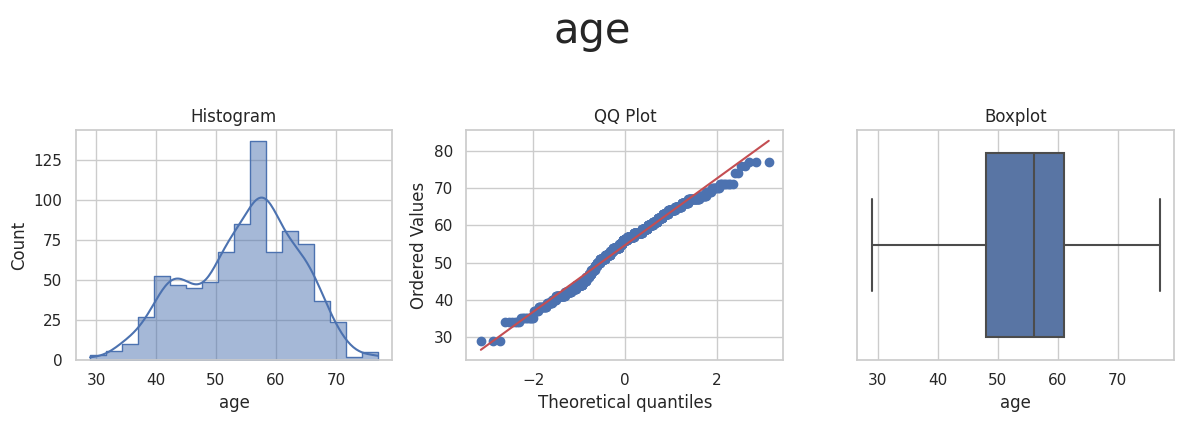

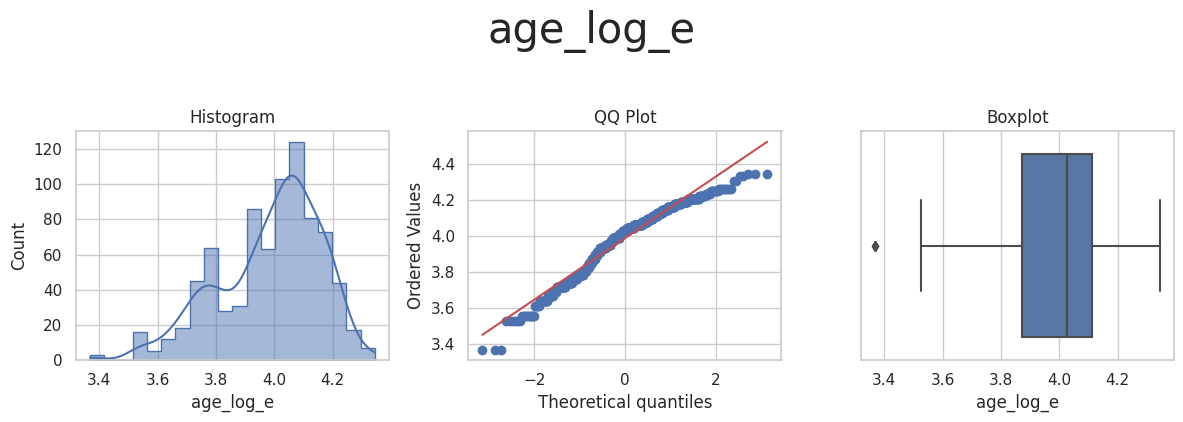

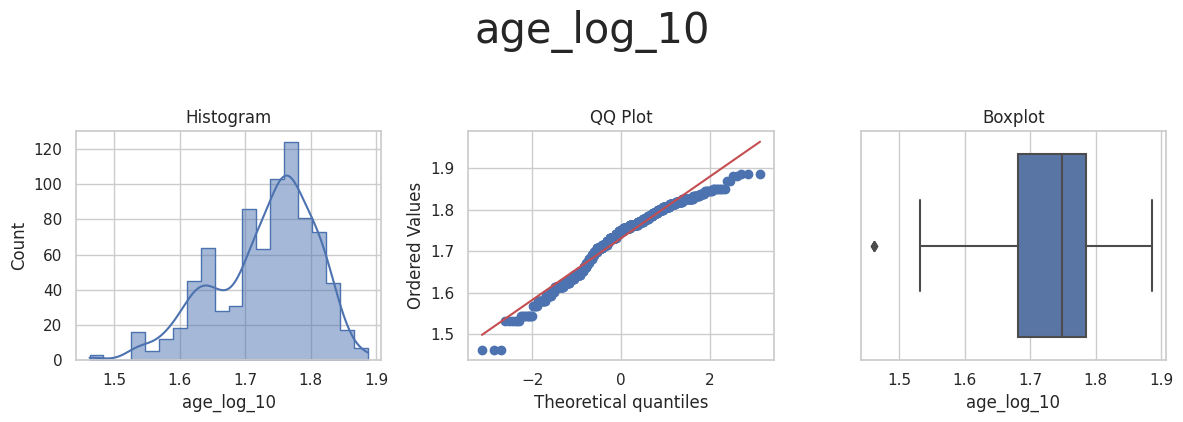

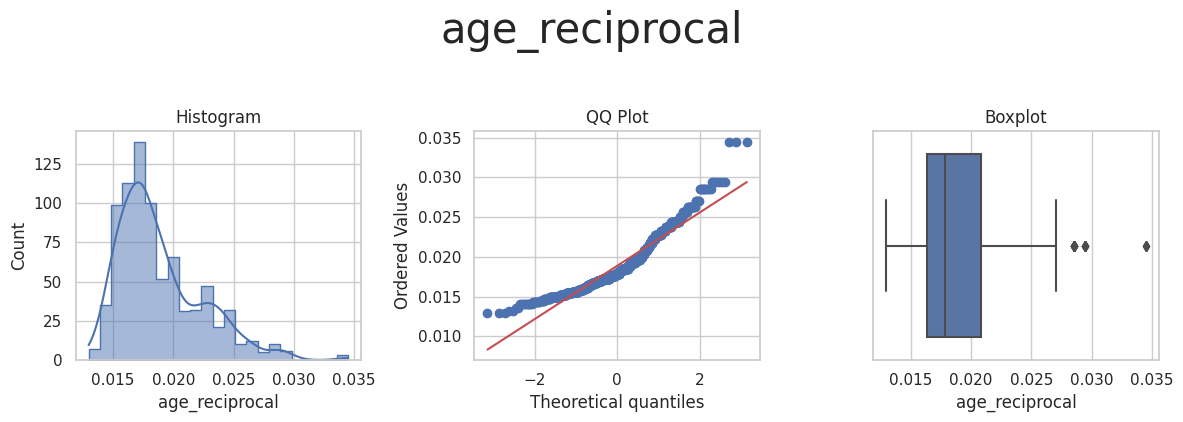

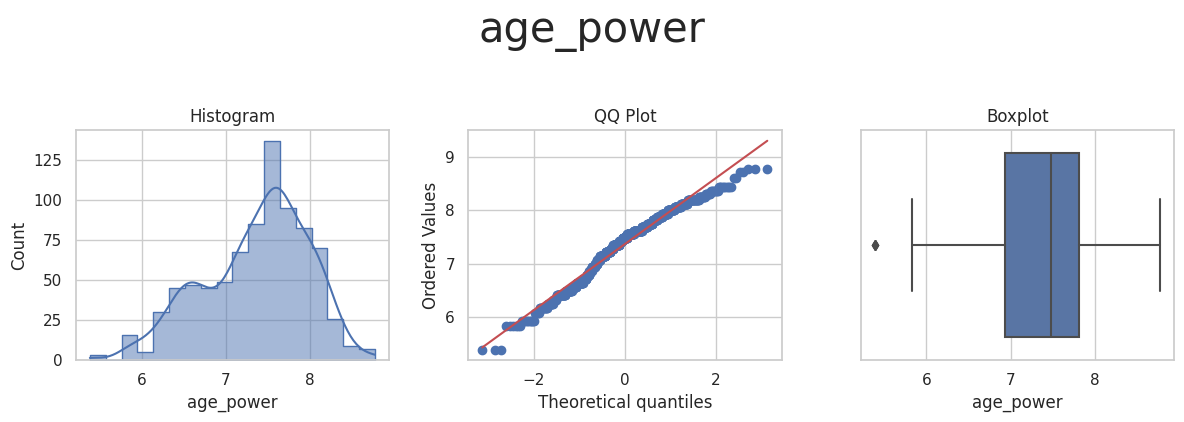

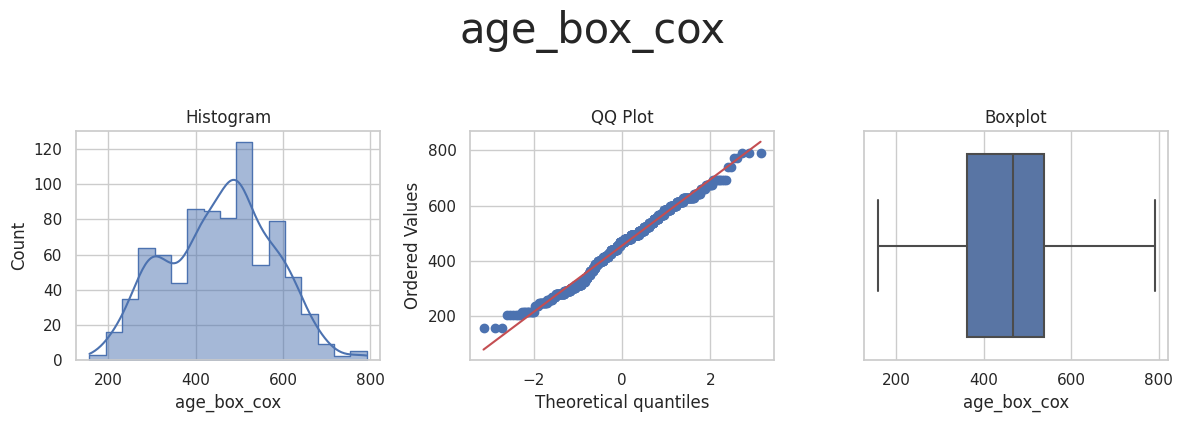

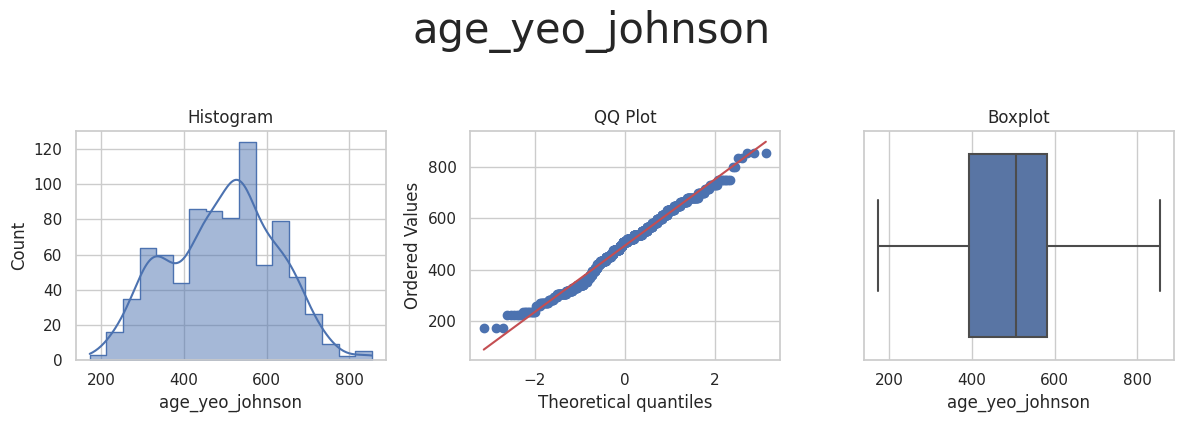



* Variable Analyzed: sex
* Applied transformation: ['sex_power', 'sex_yeo_johnson'] 



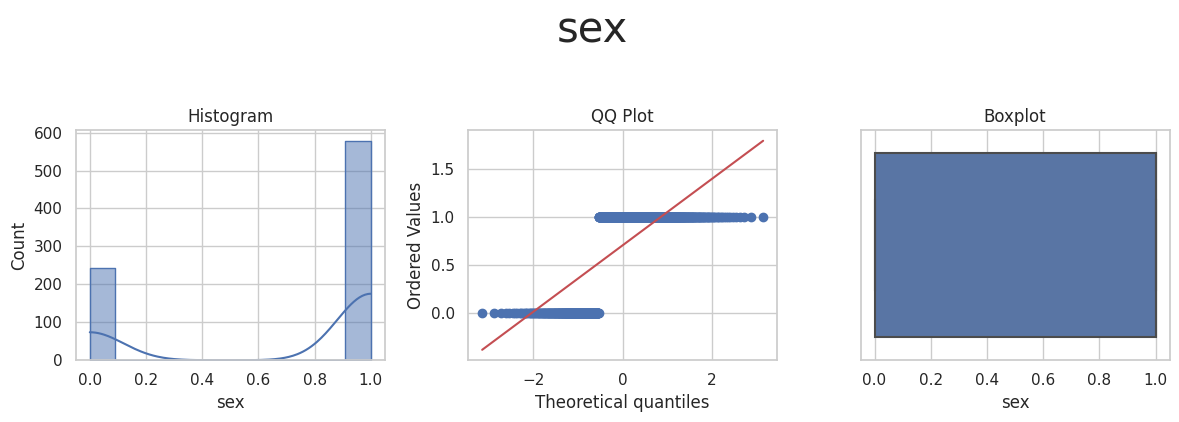

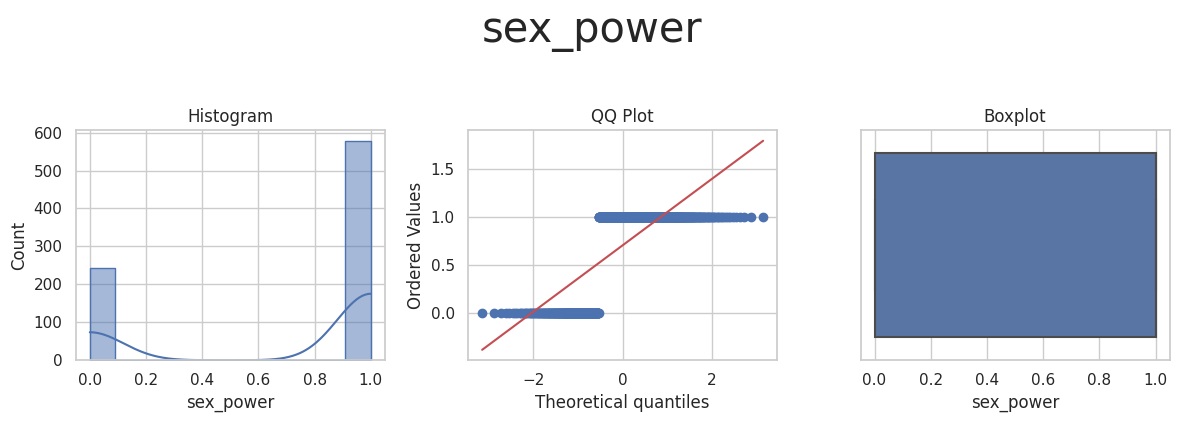

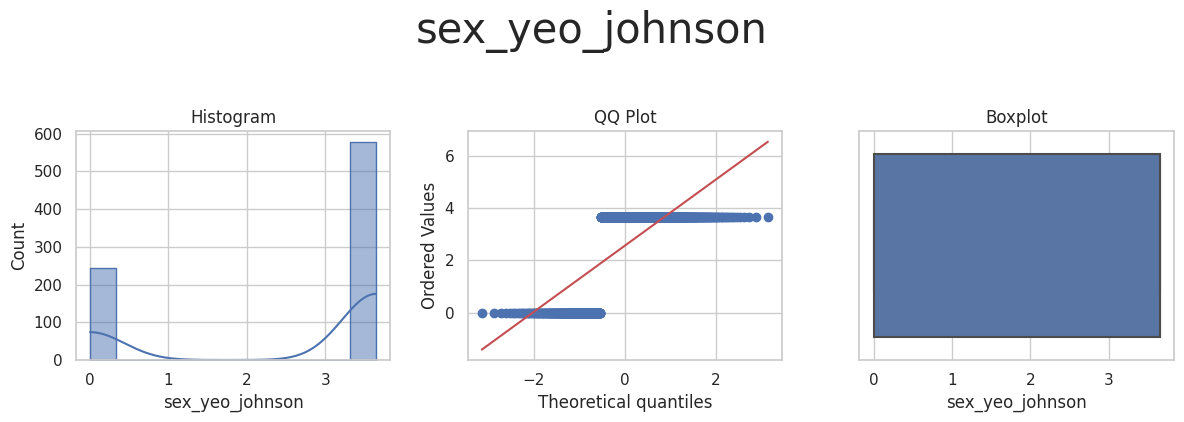



* Variable Analyzed: cp
* Applied transformation: ['cp_power', 'cp_yeo_johnson'] 



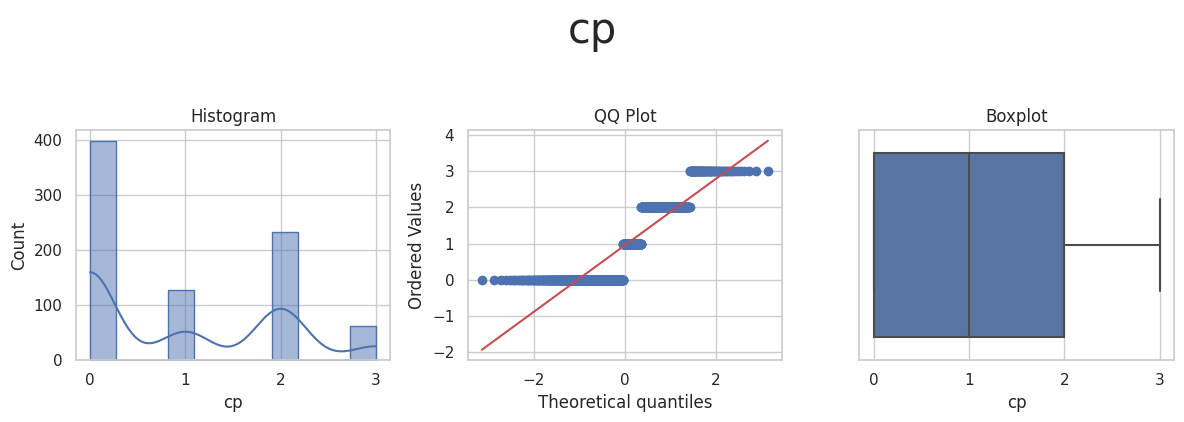

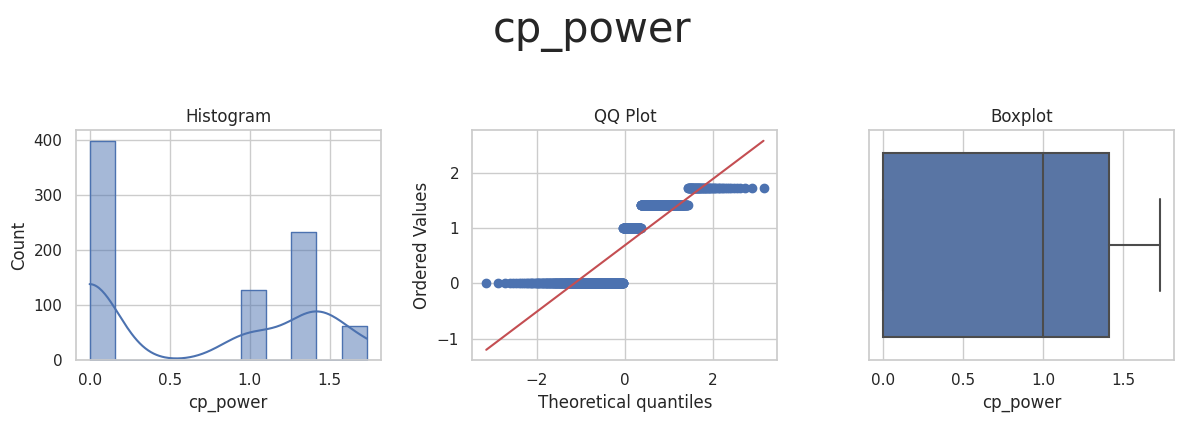

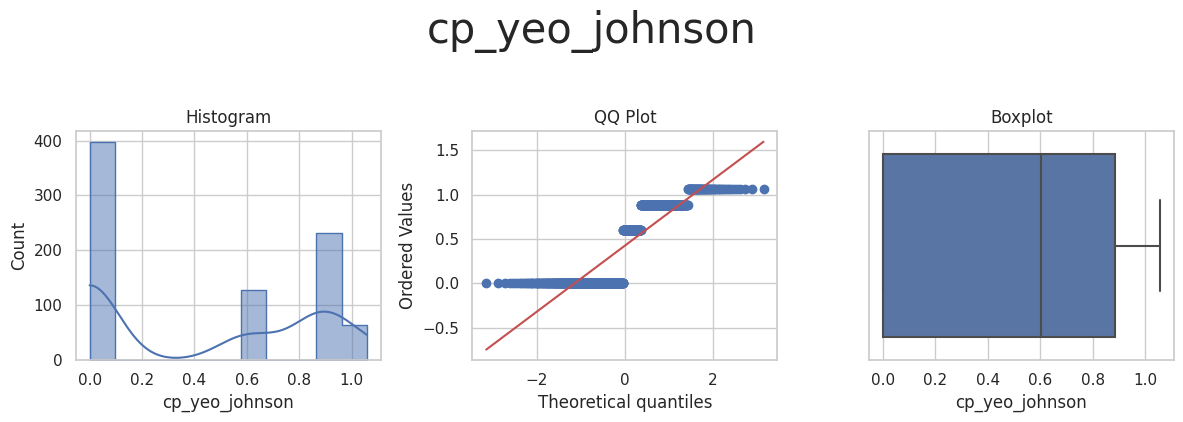



* Variable Analyzed: trestbps
* Applied transformation: ['trestbps_log_e', 'trestbps_log_10', 'trestbps_reciprocal', 'trestbps_power', 'trestbps_box_cox', 'trestbps_yeo_johnson'] 



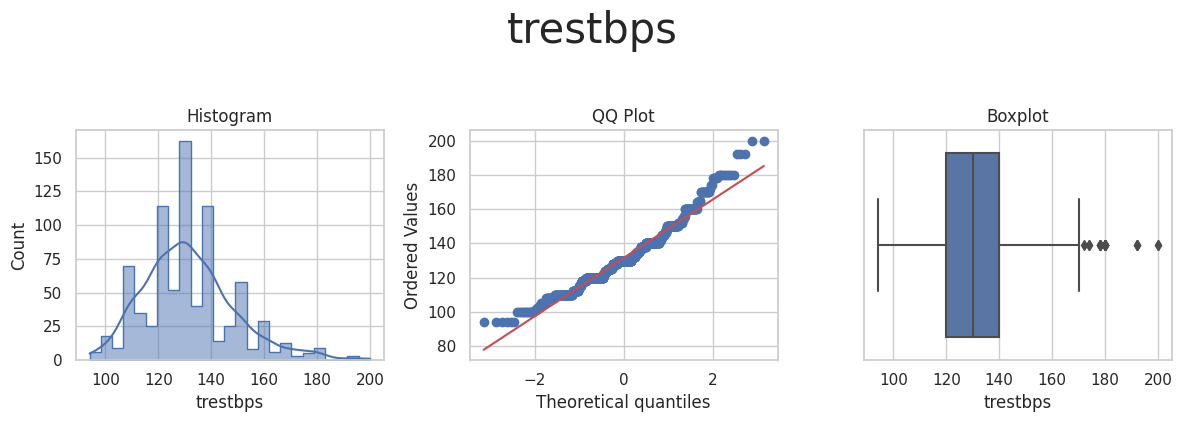

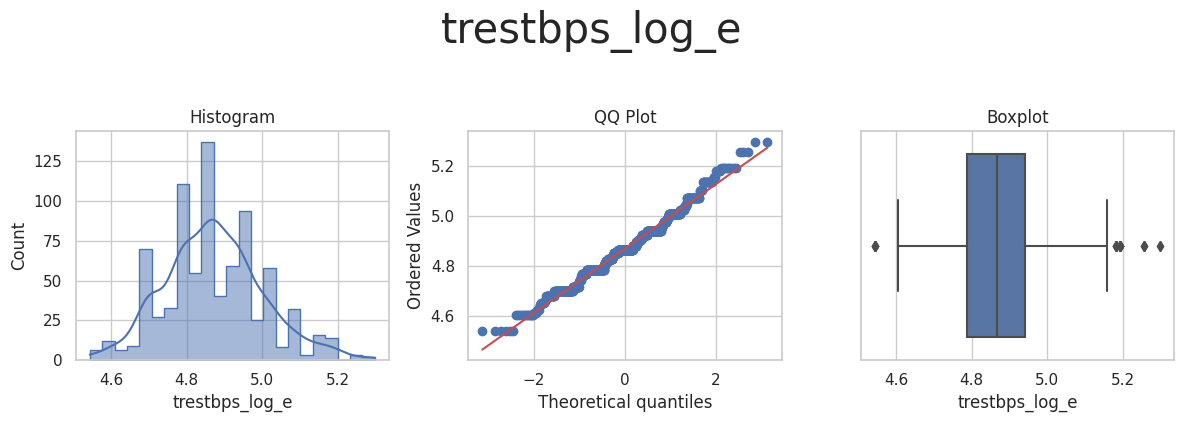

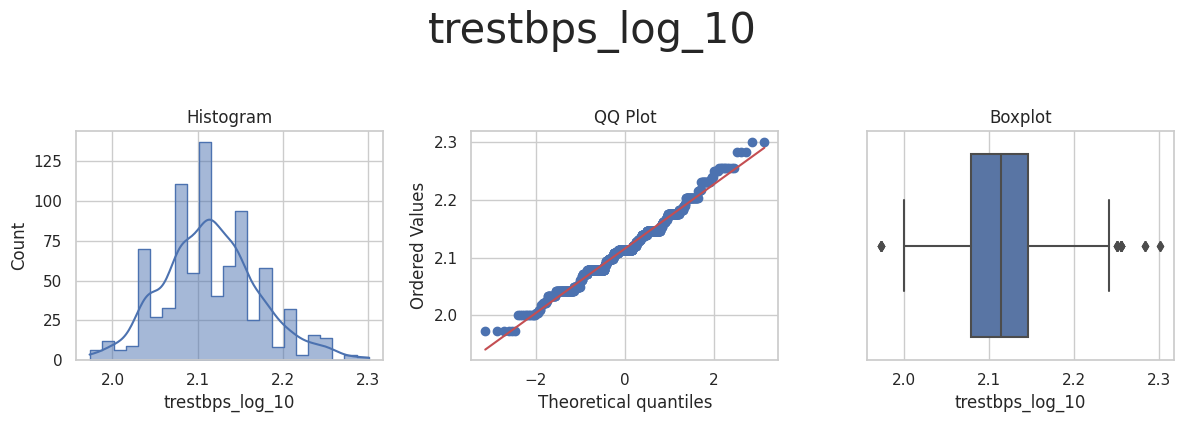

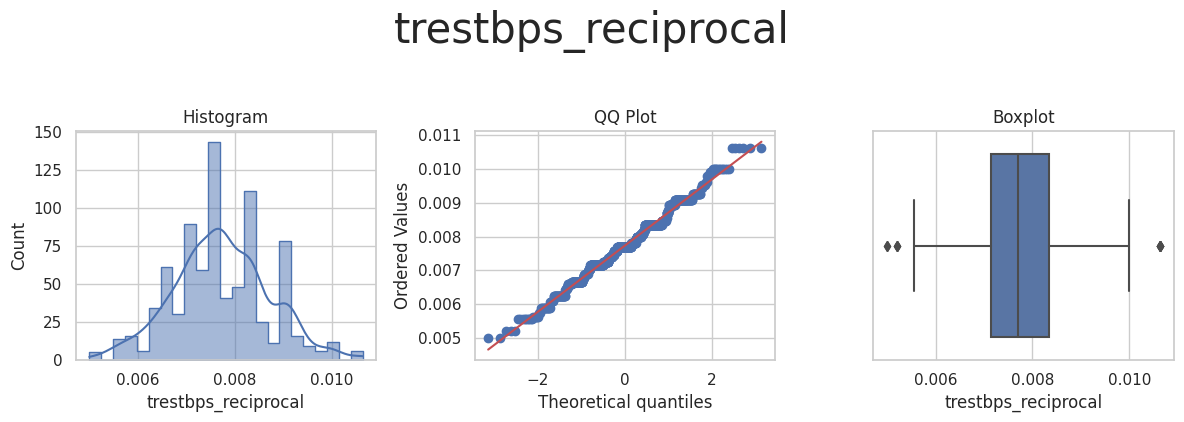

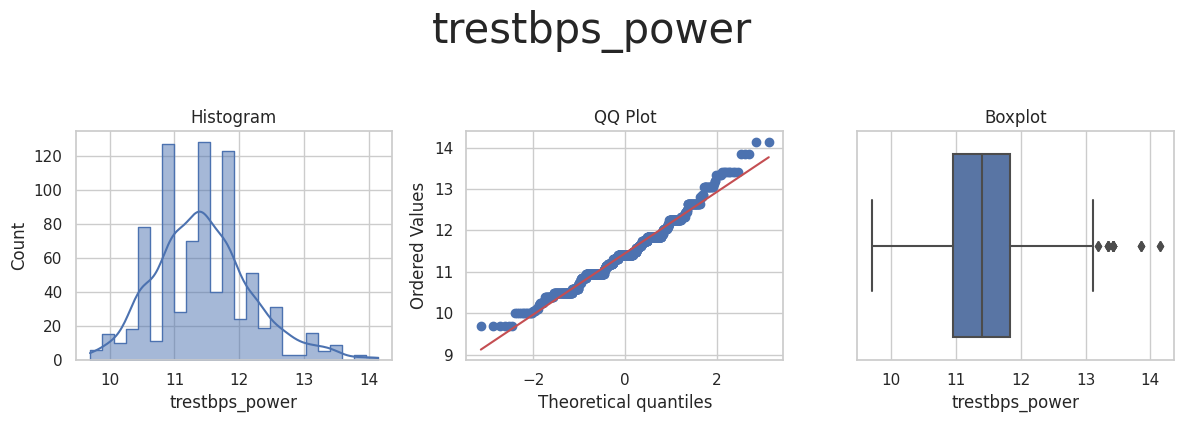

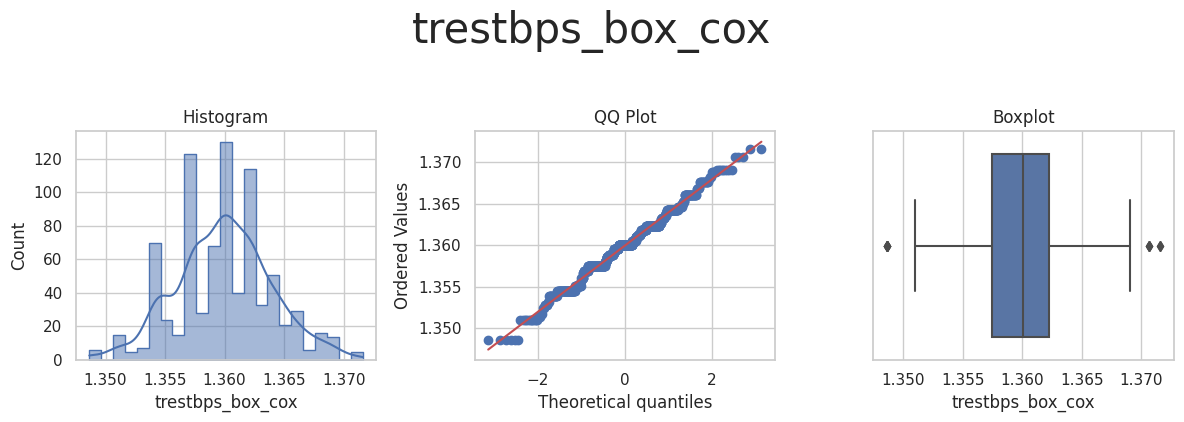

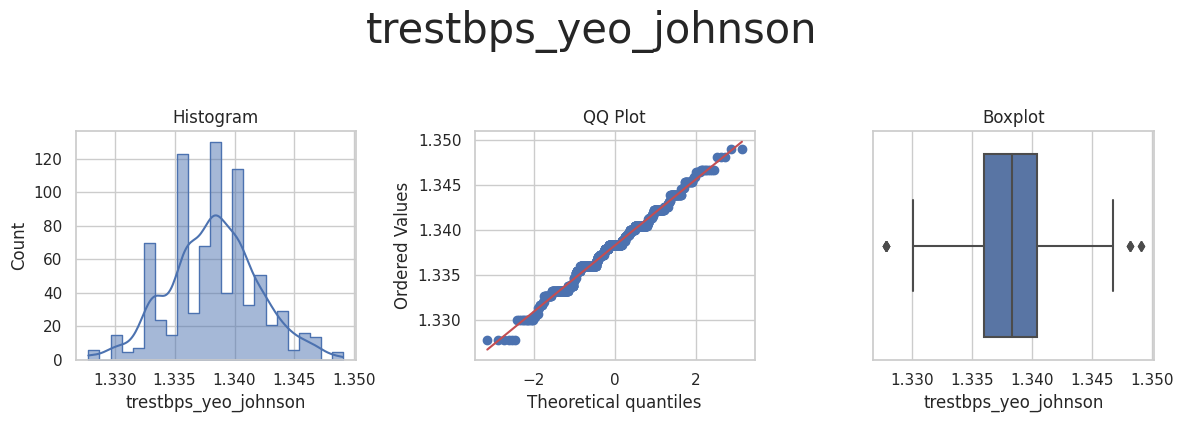



* Variable Analyzed: chol
* Applied transformation: ['chol_log_e', 'chol_log_10', 'chol_reciprocal', 'chol_power', 'chol_box_cox', 'chol_yeo_johnson'] 



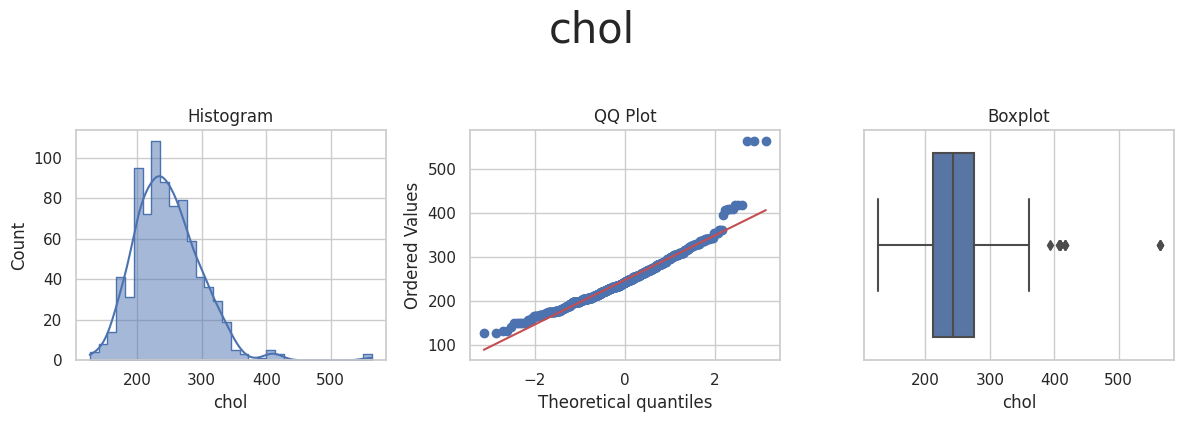

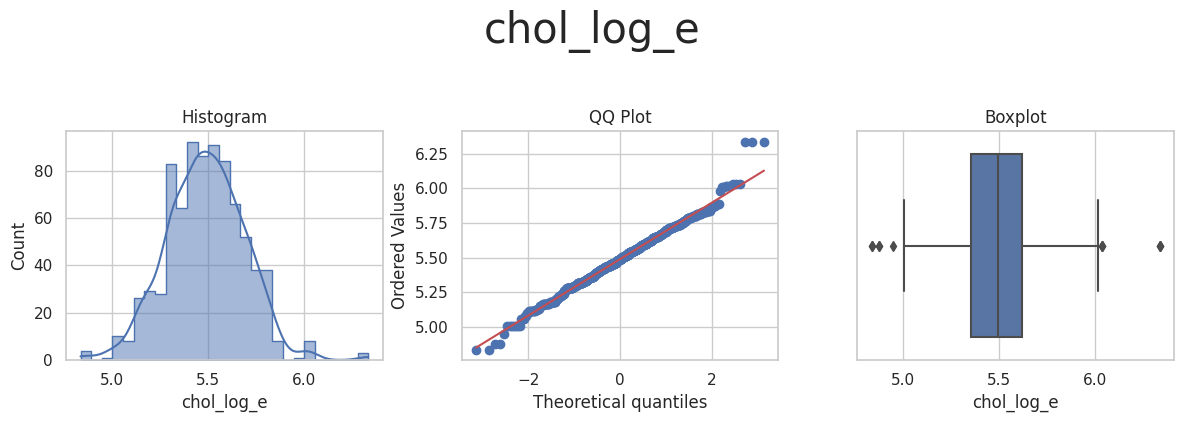

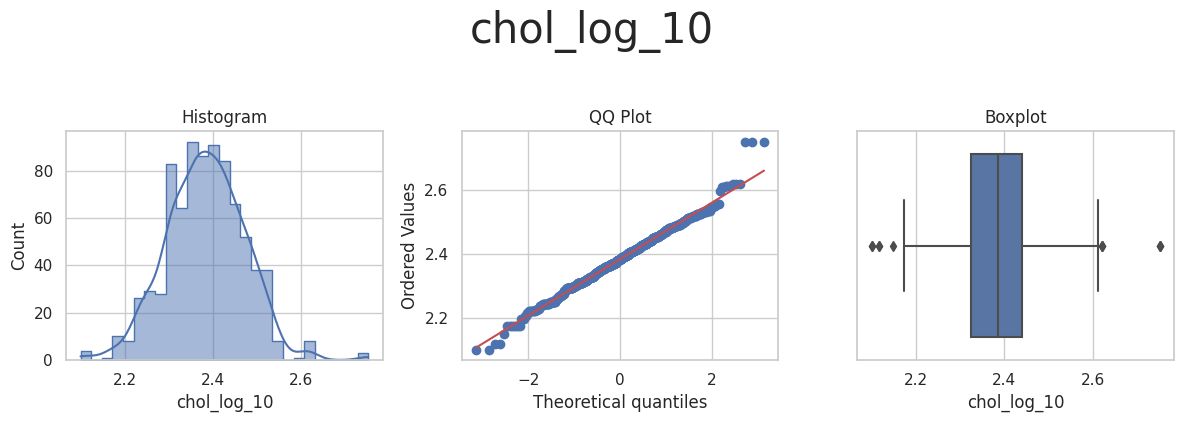

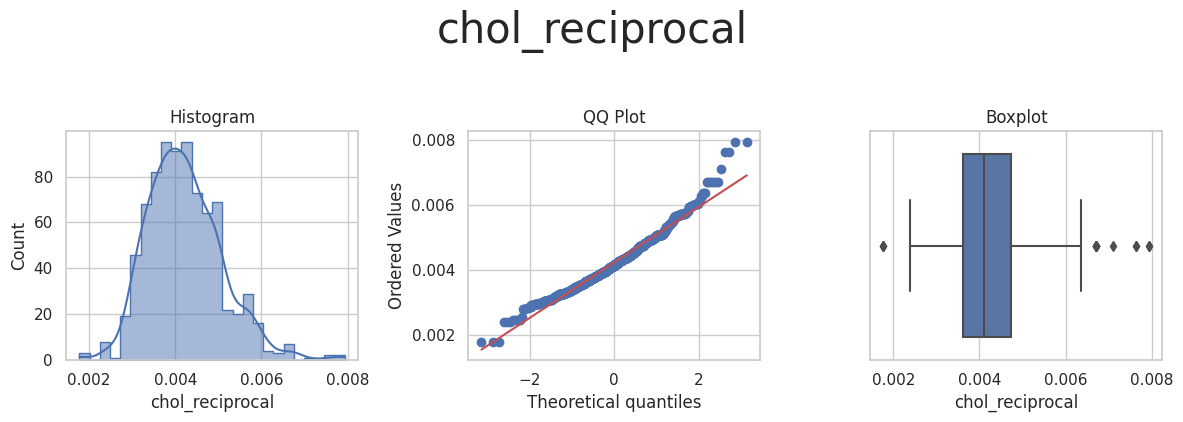

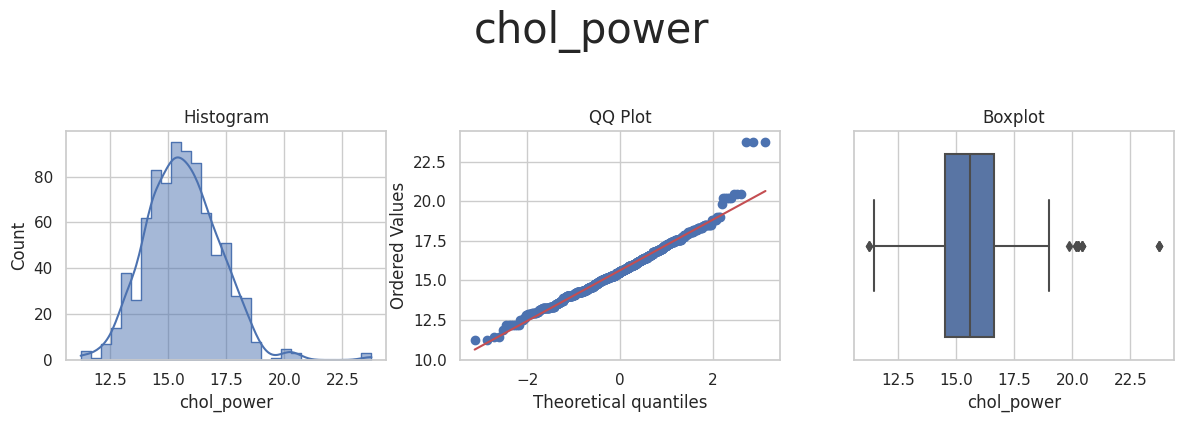

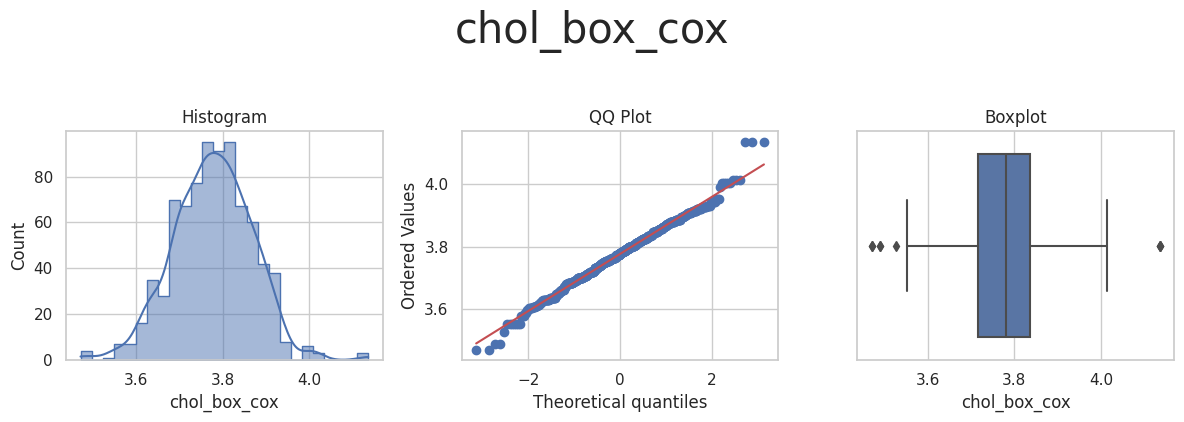

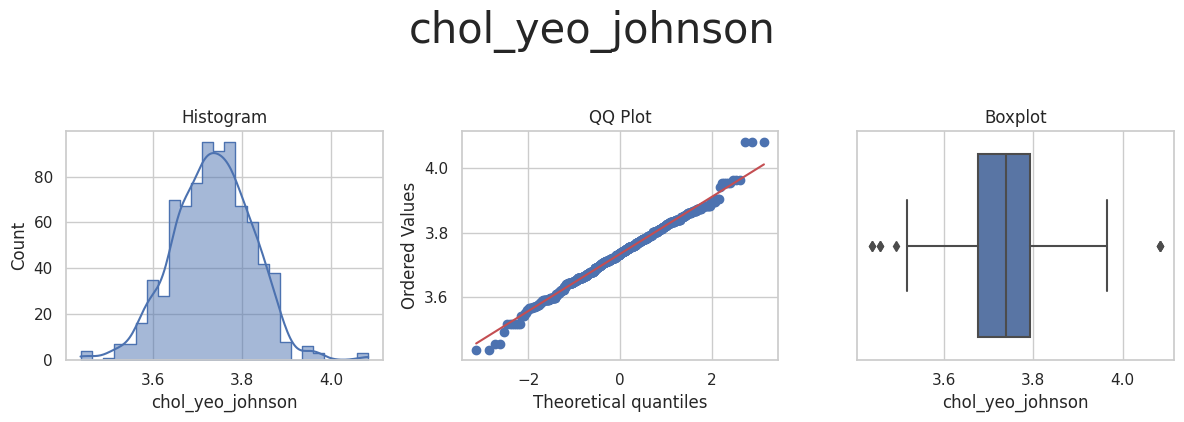



* Variable Analyzed: fbs
* Applied transformation: ['fbs_power', 'fbs_yeo_johnson'] 



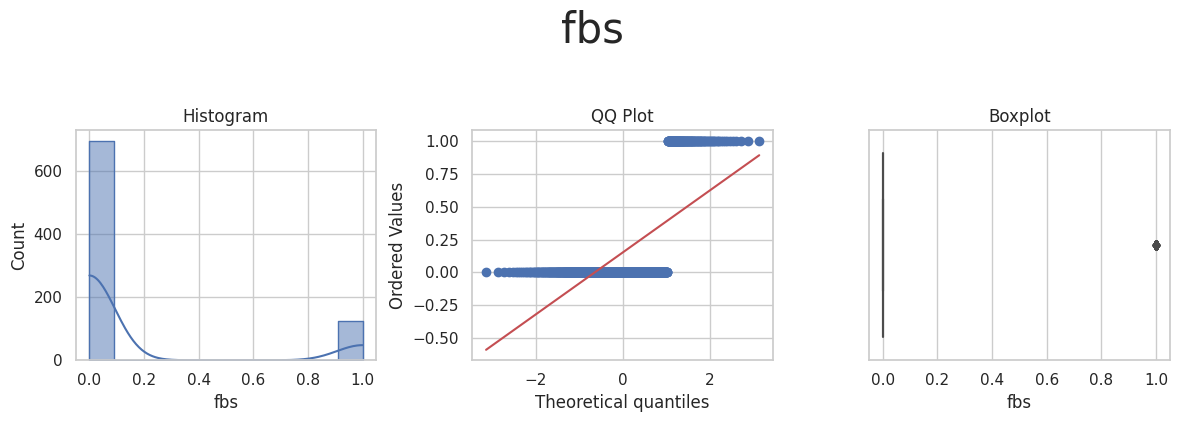

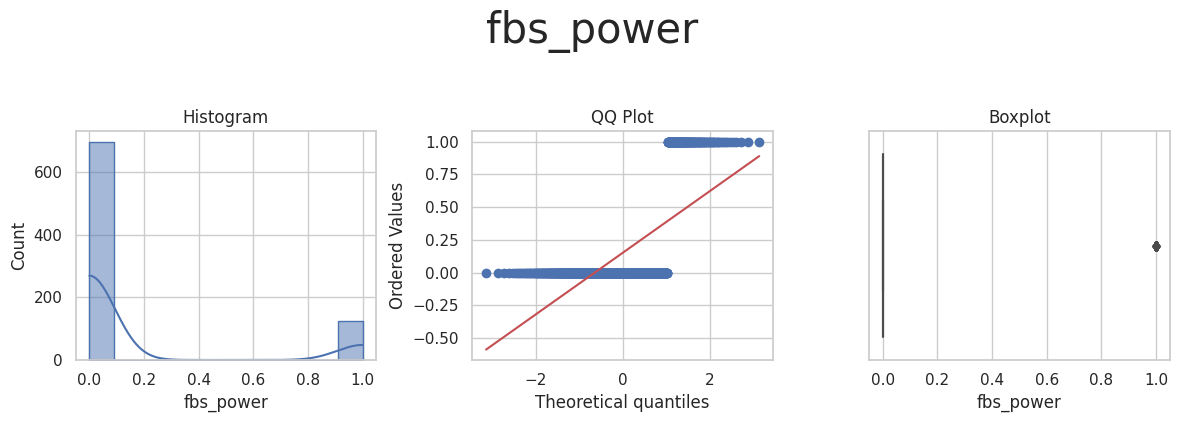

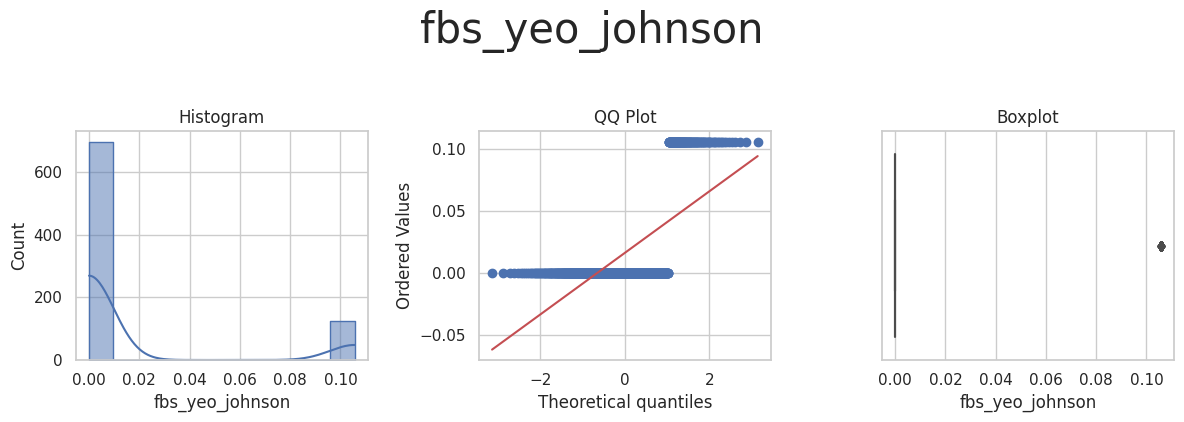



* Variable Analyzed: restecg
* Applied transformation: ['restecg_power', 'restecg_yeo_johnson'] 



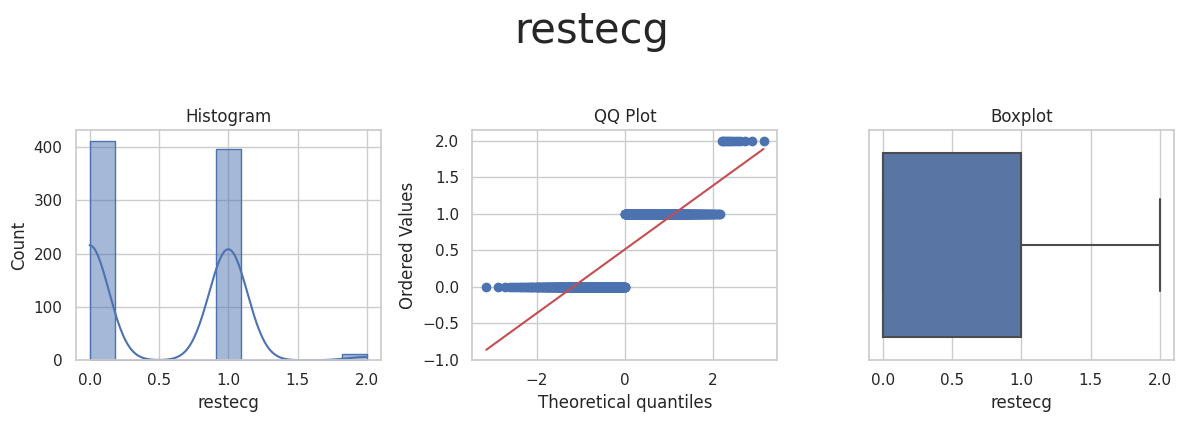

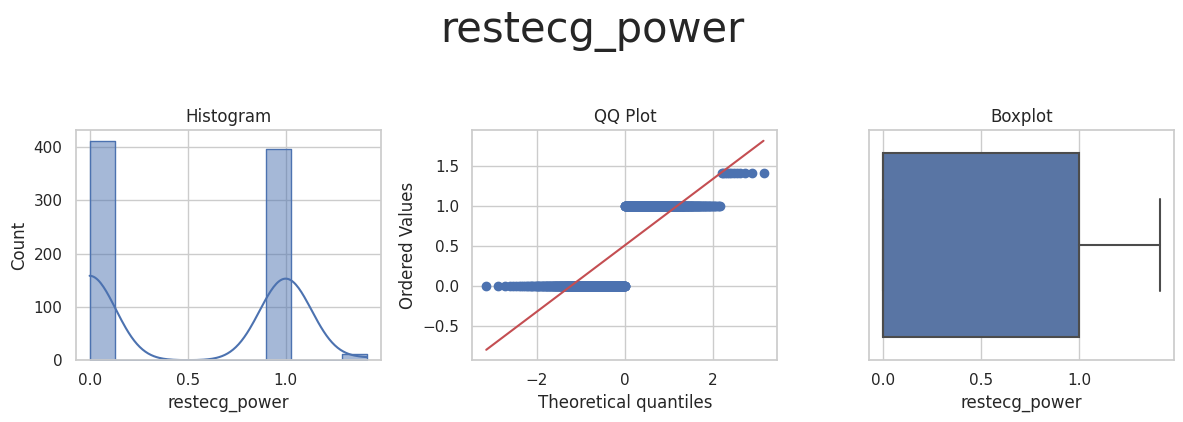

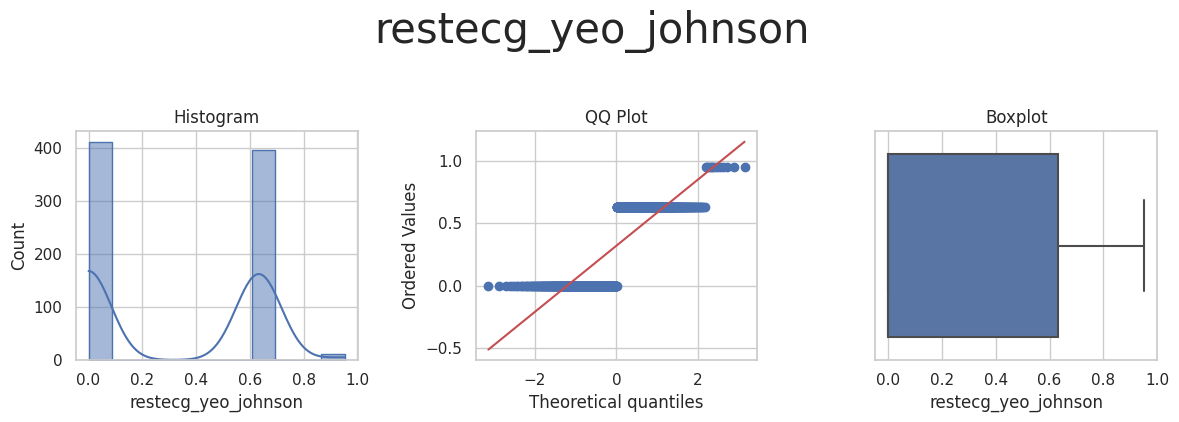



* Variable Analyzed: thalach
* Applied transformation: ['thalach_log_e', 'thalach_log_10', 'thalach_reciprocal', 'thalach_power', 'thalach_box_cox', 'thalach_yeo_johnson'] 



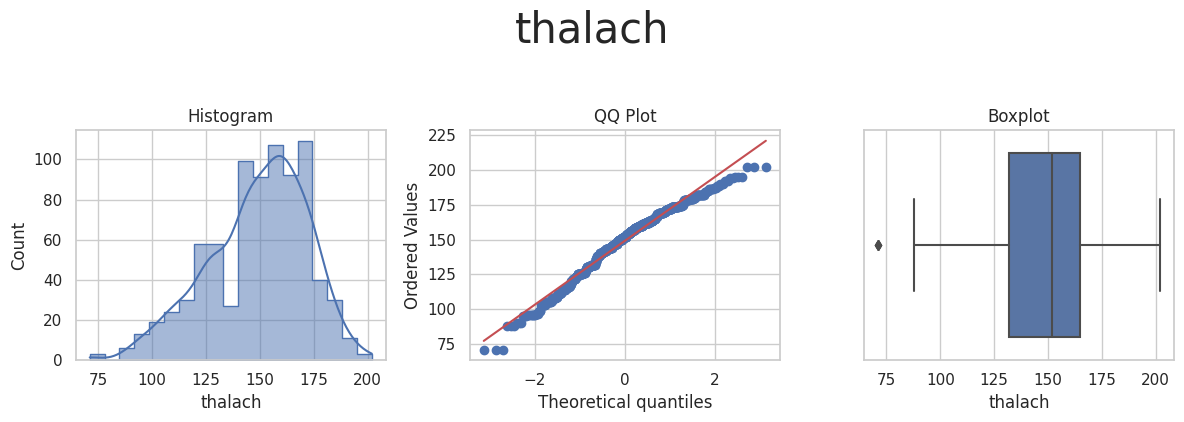

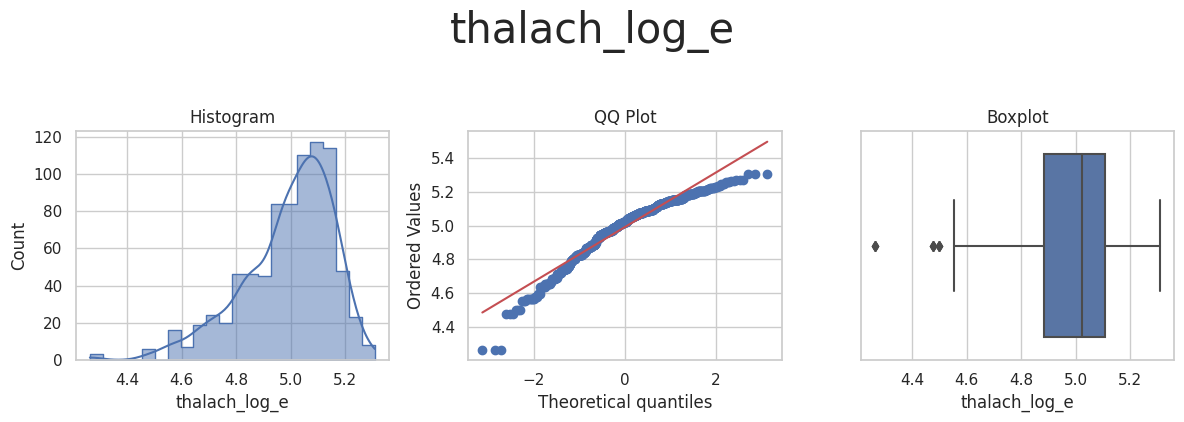

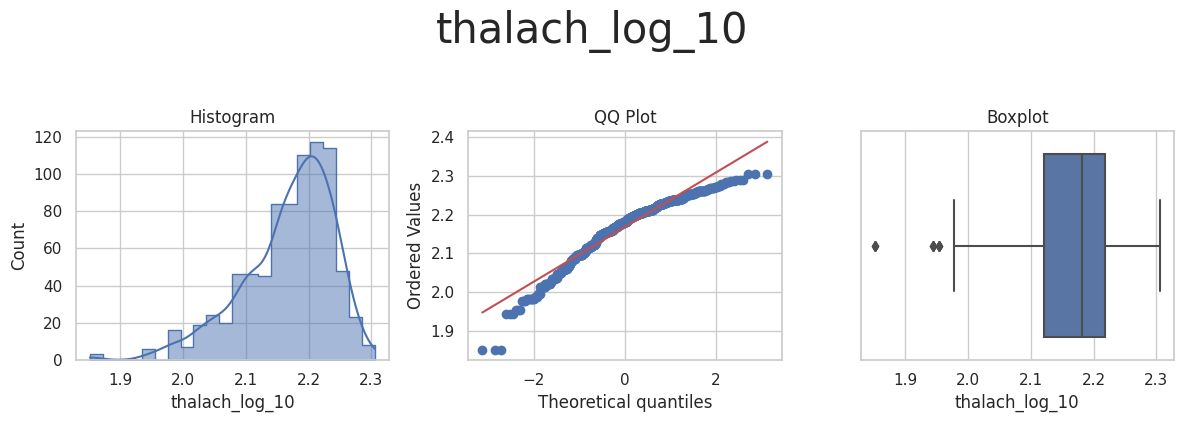

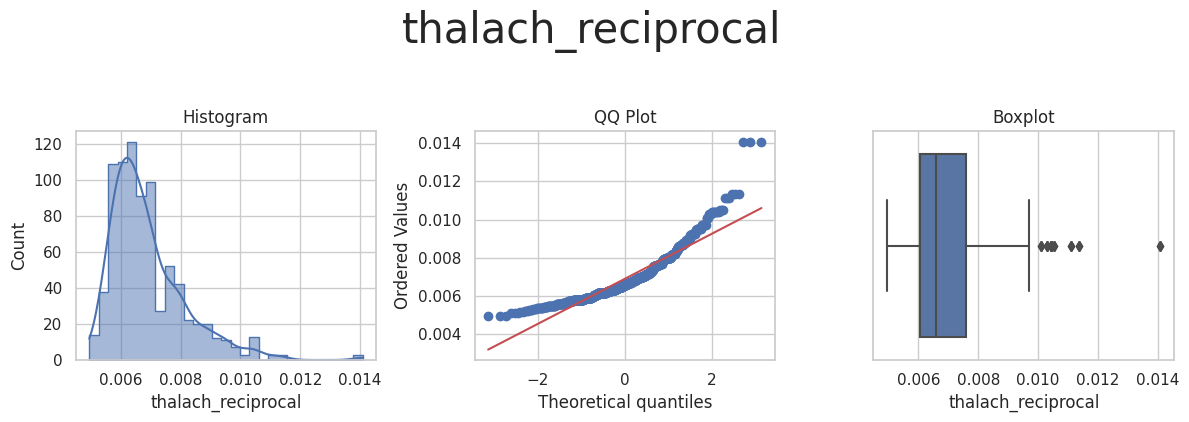

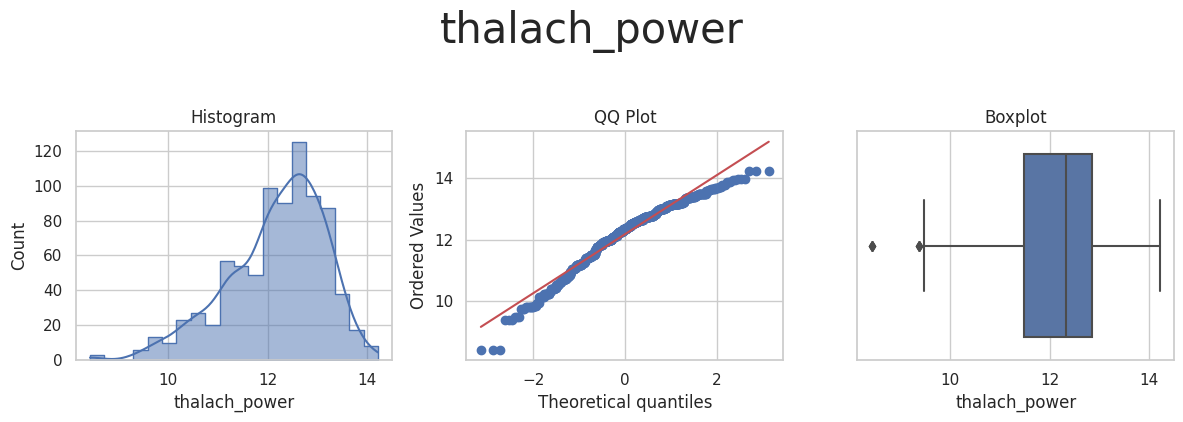

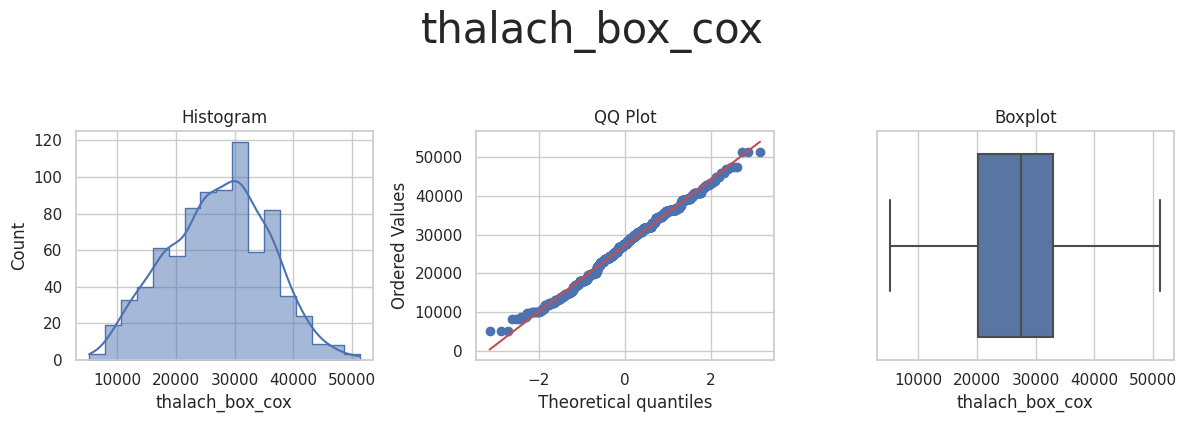

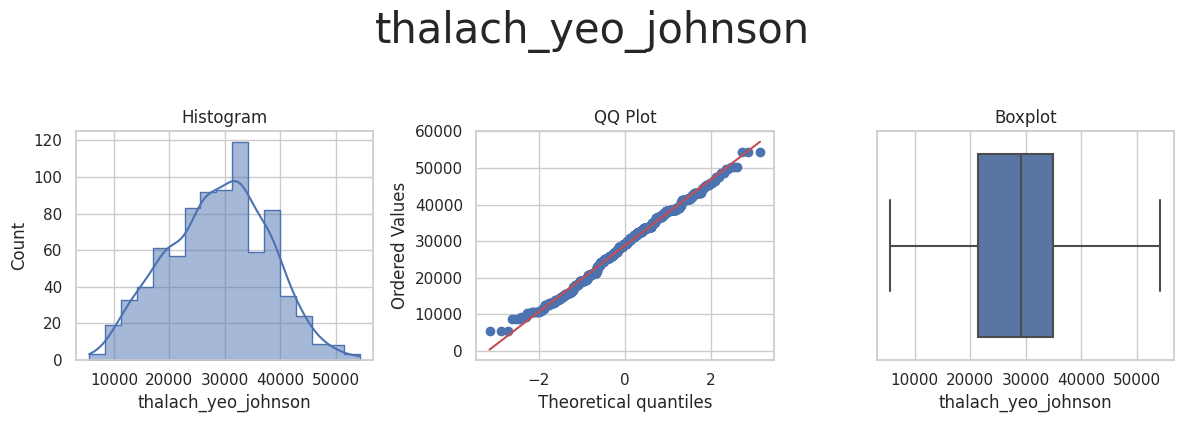



* Variable Analyzed: exang
* Applied transformation: ['exang_power', 'exang_yeo_johnson'] 



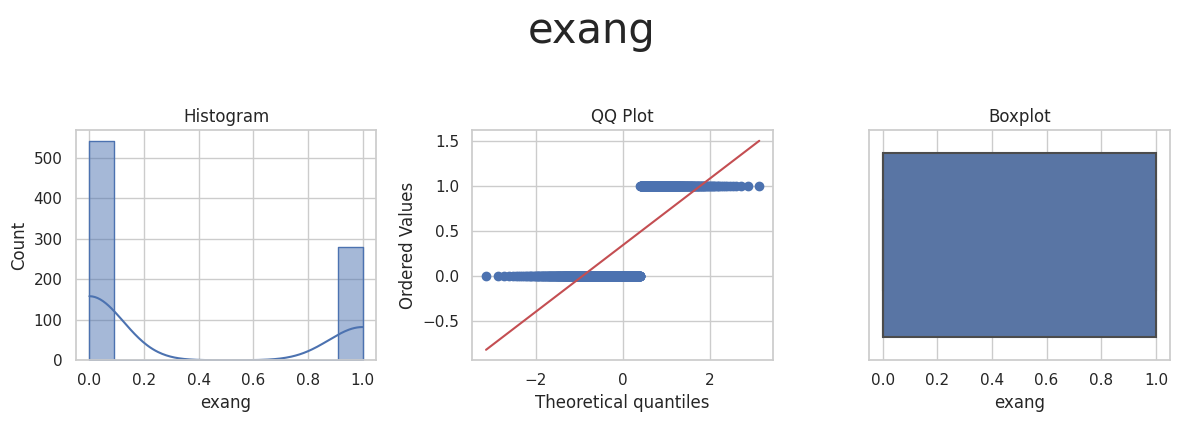

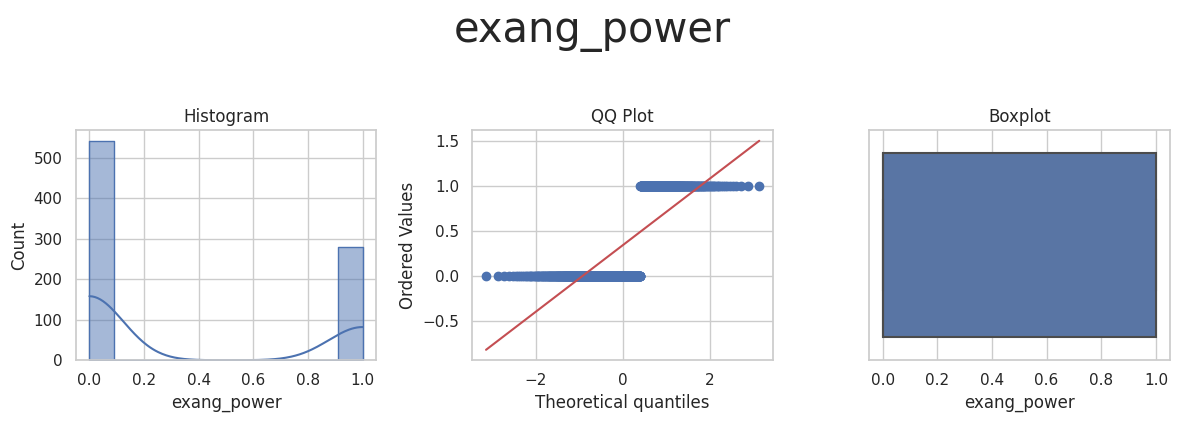

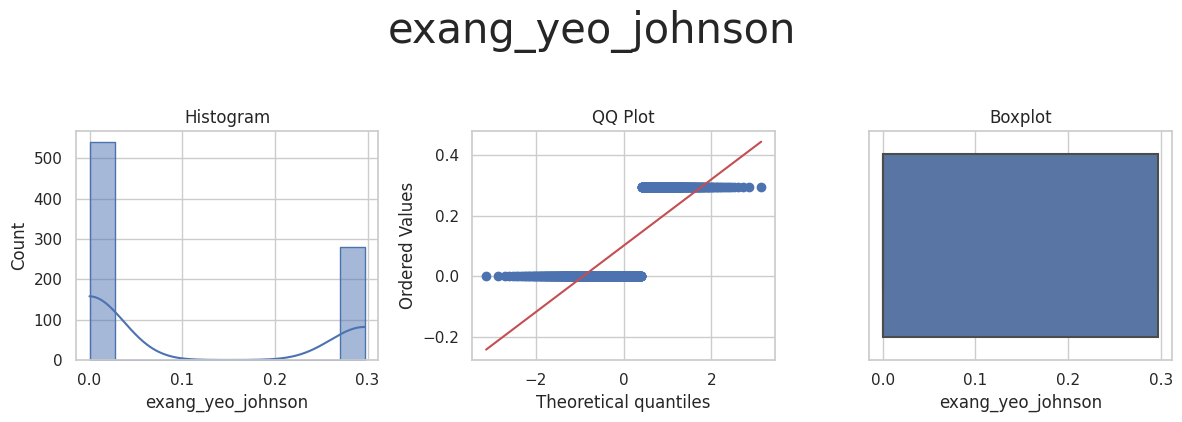



* Variable Analyzed: oldpeak
* Applied transformation: ['oldpeak_power', 'oldpeak_yeo_johnson'] 



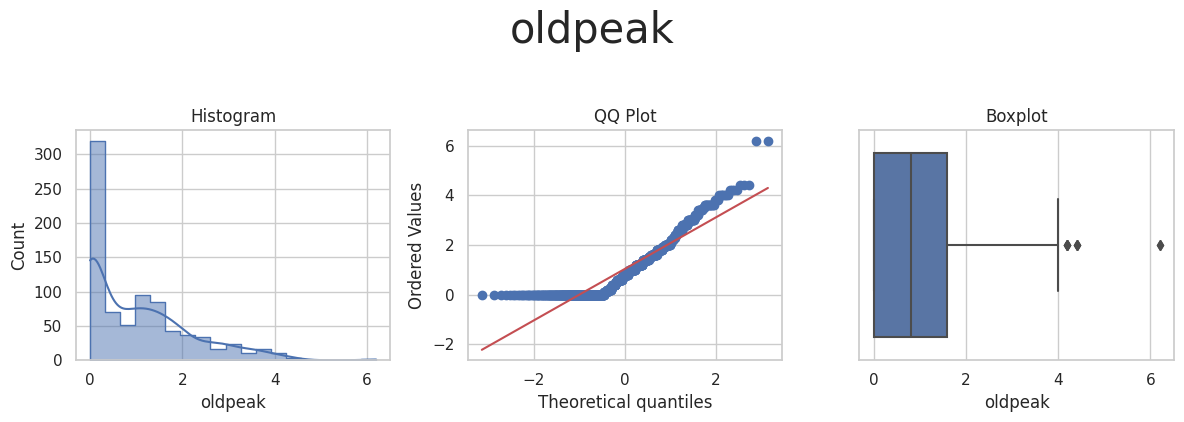

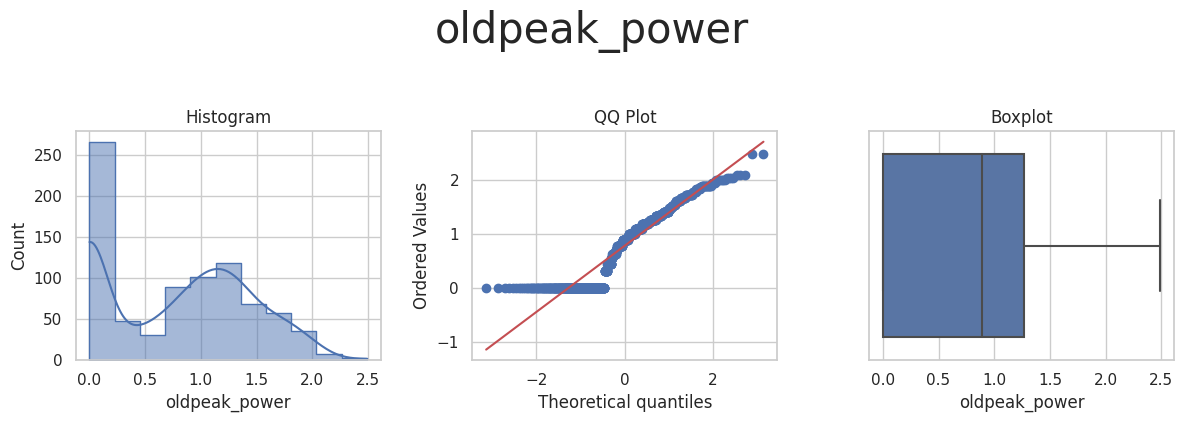

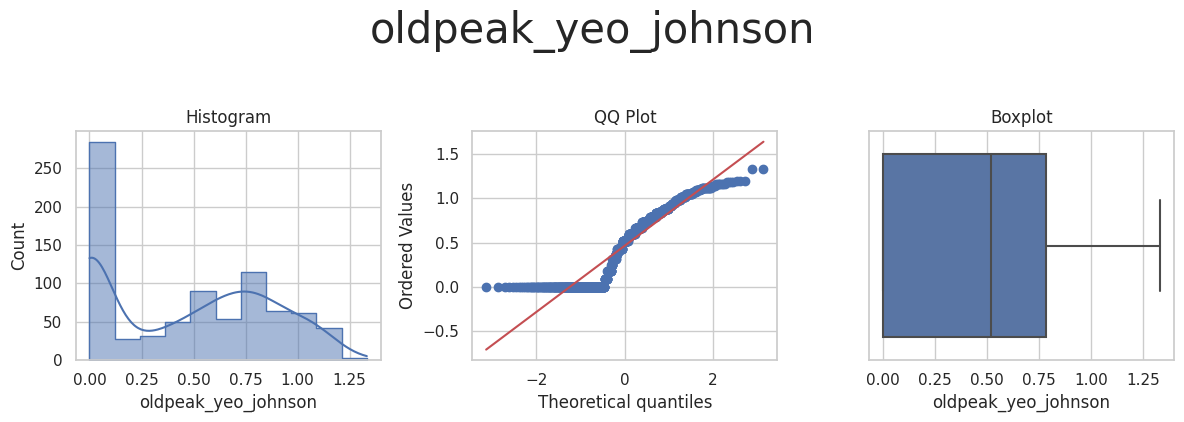



* Variable Analyzed: slope
* Applied transformation: ['slope_power', 'slope_yeo_johnson'] 



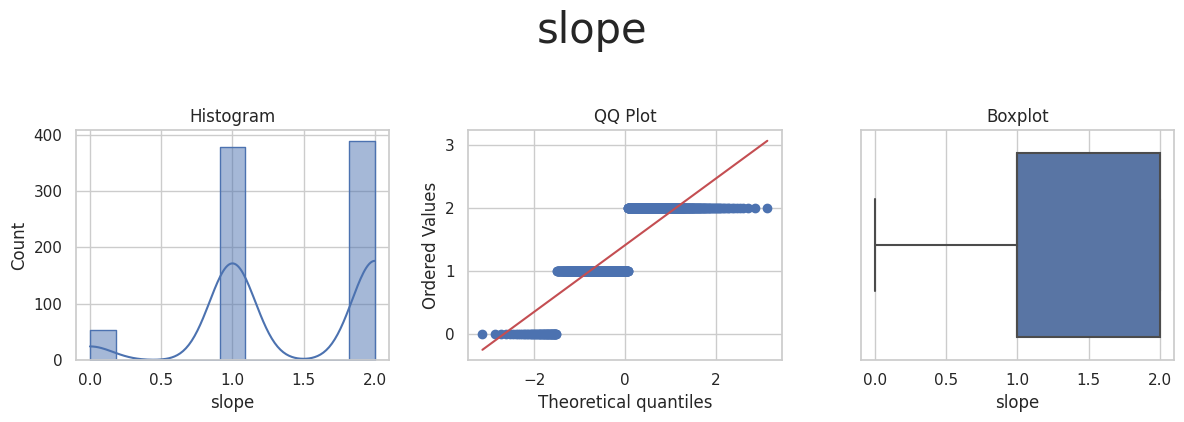

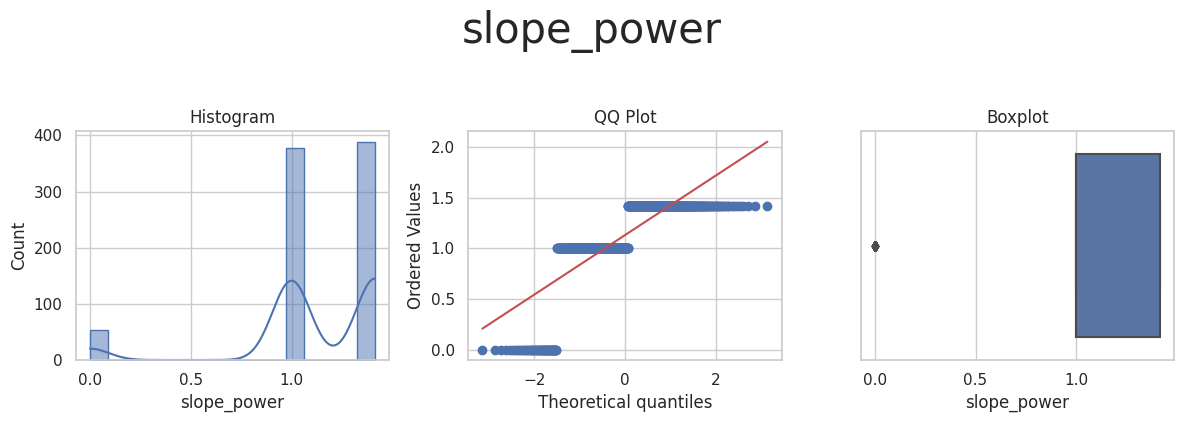

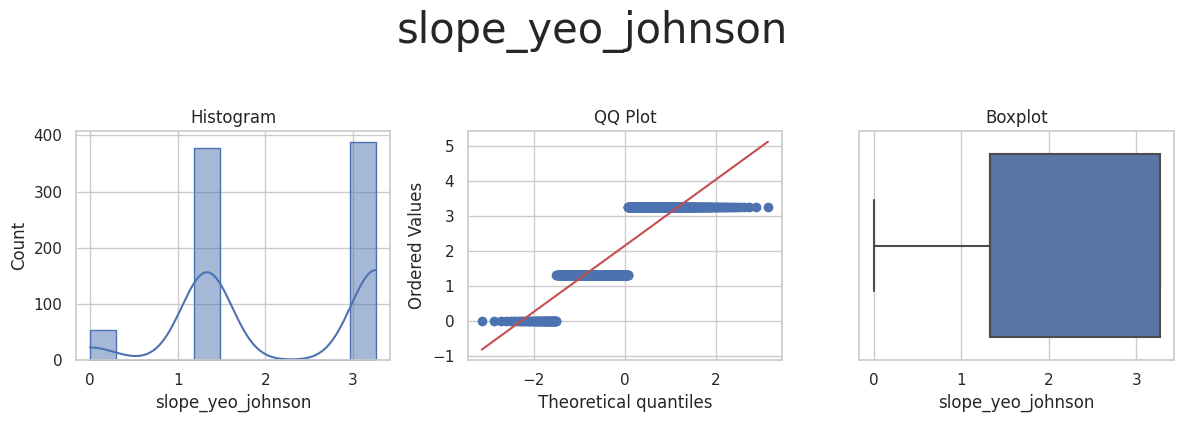



* Variable Analyzed: ca
* Applied transformation: ['ca_power', 'ca_yeo_johnson'] 



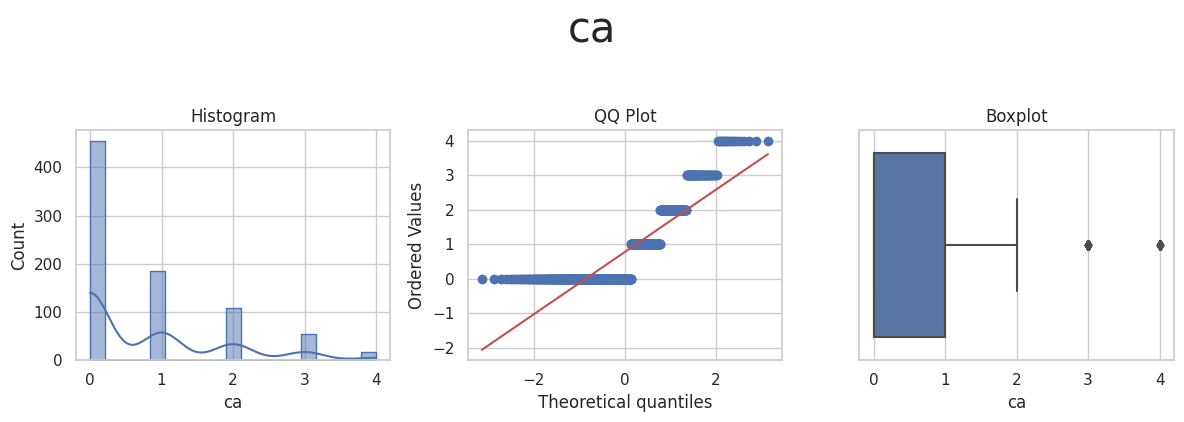

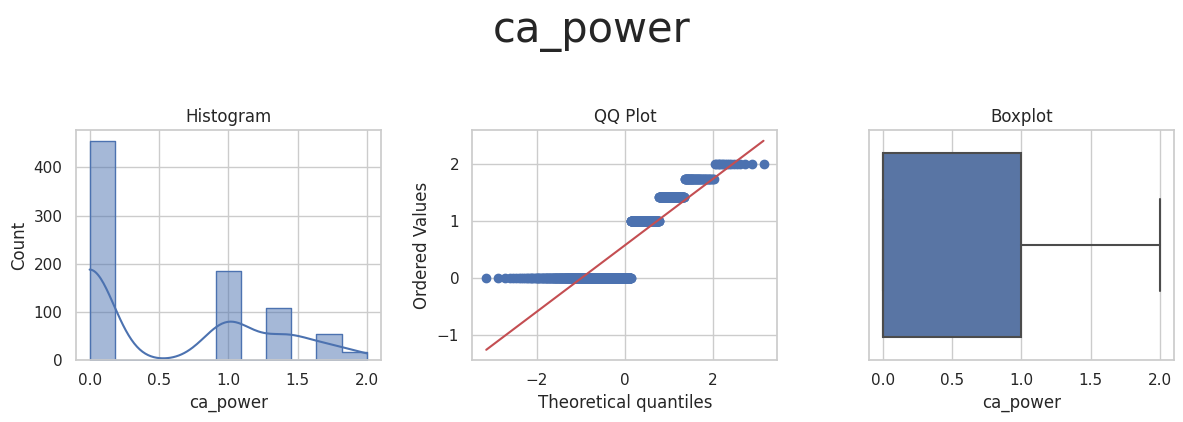

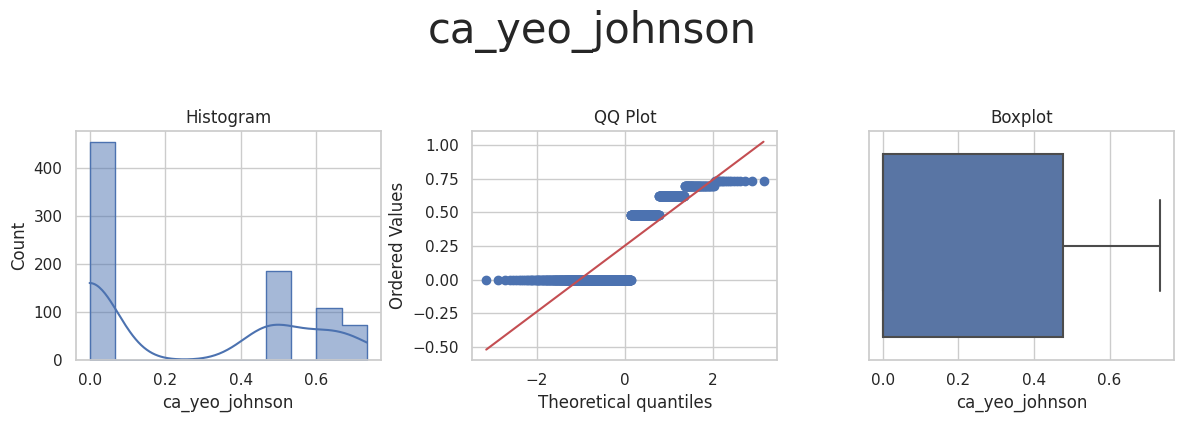



* Variable Analyzed: thal
* Applied transformation: ['thal_power', 'thal_yeo_johnson'] 



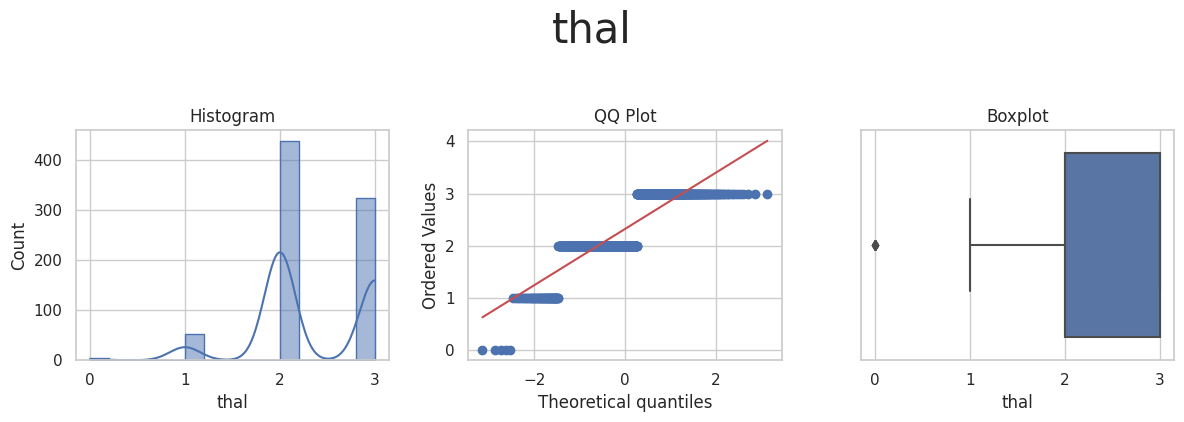

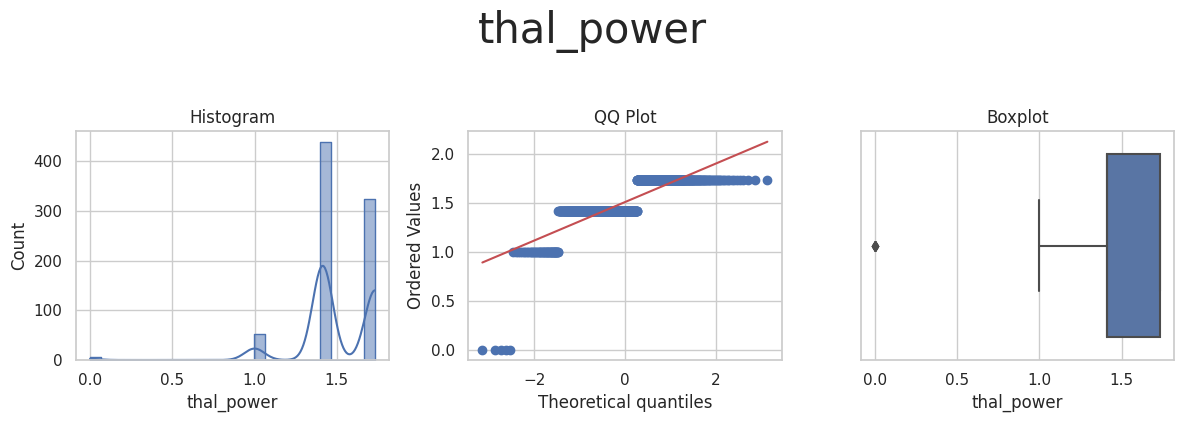

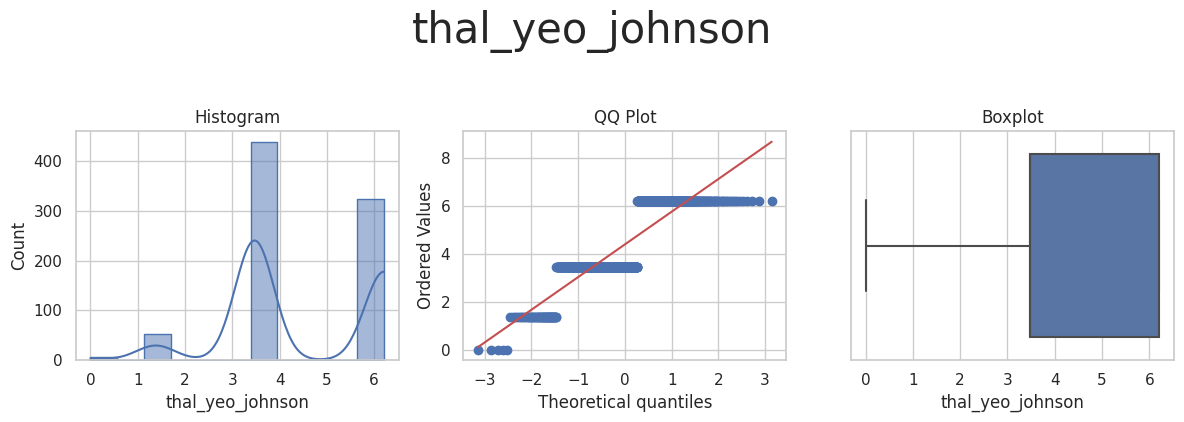

In [7]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

Performing shapiro test to assess normality of the data

In [8]:
import scipy.stats as stats

# Perform the Shapiro-Wilk test
statistic, p_value = stats.shapiro(df_engineering)

# Check the p-value
if p_value < 0.05:
    print("The data significantly deviates from a normal distribution.")
else:
    print("The data does not significantly deviate from a normal distribution.")

The data significantly deviates from a normal distribution.


In [9]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# Create a DataFrame to store the results
before_transformation_results = pd.DataFrame(columns=["Variable", "Shapiro-Wilk p-value (Before)"])

for column in df_engineering.columns:
    # Extract the data for the current column
    data = df_engineering[column].values

    # Before Transformation:
    # Perform the Shapiro-Wilk test for normality
    statistic_before, p_value_before = stats.shapiro(data)

    # Append the results to the DataFrame
    before_transformation_results = before_transformation_results.append({
        "Variable": column,
        "Shapiro-Wilk p-value (Before)": p_value_before
    }, ignore_index=True)

# Print the results for the original data (before transformation)
print("Results Before Transformation:")
print(before_transformation_results)


Results Before Transformation:
                Variable  Shapiro-Wilk p-value (Before)
0                    age                   2.824851e-08
1              age_log_e                   1.864462e-14
2             age_log_10                   1.864462e-14
3         age_reciprocal                   4.372385e-21
4              age_power                   3.673436e-11
5            age_box_cox                   3.605074e-06
6        age_yeo_johnson                   3.693160e-06
7                    sex                   1.168206e-40
8              sex_power                   1.168206e-40
9        sex_yeo_johnson                   1.168206e-40
10                    cp                   1.491282e-31
11              cp_power                   2.865002e-33
12        cp_yeo_johnson                   2.363786e-33
13              trestbps                   3.446681e-13
14        trestbps_log_e                   4.337710e-07
15       trestbps_log_10                   4.337710e-07
16   trestbps_rec

Here's a breakdown of the variables and potential transformation methods based on the provided data:

1. age: Consider applying a logarithmic transformation **(log_e, log_10), reciprocal transformation, or Box-Cox/Yeo-Johnson** transformation with an estimated lambda.2. 
sex: This binary variablmay***y not benef**it frotransformationsns. It's typically left as-is for classification task
3. 

cp (chest pain type): Depending on the nature of the data, conr sir a Box-Cox/Yeooh****nson transformation with an estimatembda 4. aa.

trestbps (resting blood pressure): Consider a logarithmic traation nsation (log_e, log_10), reciprocal transformation, or Box-Coxohnson/Yhnson transformation with an estima5. bbda.

chol (serum cholesterol): Consider a logarithmicrmaansortion  trmation (log_e, log_10), reciprocal transformat**Box-Cox/Yeo-Johnson**-Johnson transformation with an eted l -6. ambda.

fbs (fasting blood sugar): Thiry var******iable may n**ofrom transformationsformations. It's typical it y left as-is for cficatio -7. n tasks.

restecg (resting electrocardiographic results): Depending on the nature ofthe data,** consid/Yeo-Johnsoner/Yeo-Johnson transformation wn estimat -8. ed lambda.

thalach (maximum heart rate achieved): Consider a logarithmic transformation (log_e, log_10), reprocal trans****formaon, or Box-C****ox/Yeo-Johnson transformationith an estim -9. ated lambda.

exang (exercise-induced anna): This bina****ry variable may t benefit from*** transformations. It's typically left ais for classif -10. ication tasks.

oldpeak (ST depression induced by exercise): Depending on e nature of the**** ta, consider a B****ox-Cox/Yeo-Johnson transfmation with an e  11. stimated lambda.

slope (slope of the peak exercise ST segment): Dependinon the nature of t* *h data, consider a**** Box-Cox/Yeo-Johnson transformation with an  12.  estimated lambda.

ca (number of major vessels colored by fluoroscopy): Depe tg on the nature o* t**he data, consider**** a Box-Cox/Yeo-Johnsotransformation with   13. an estimated lambda.

thal (thalassemia): pending on the natu **of** the data, consid****er a Box-Cox/Yeo-Johnson transformation with an estimated lambda.

Based on the statistical and visual investigation , developer choose to consider **Box-Cox/Yeo-Johnson** as the transformation method, since most of the variables could benefit from it. Because box-cox give error for not positive numbers, developer chose to use **Yeo Johnson**

# Yeo Johnson Transformer

In [10]:
from feature_engine import transformation as vt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Variables that may benefit from Yeo-Johnson transformation
variables_to_transform = [
    'age',
    'cp',
    'trestbps',
    'chol',
    'restecg',
    'thalach',
    'oldpeak',
    'slope',
    'ca',
    'thal'
]

# Create a ColumnTransformer to apply Yeo-Johnson only to selected variables
column_transformer = ColumnTransformer(
    transformers=[('yeo_johnson', vt.YeoJohnsonTransformer(), variables_to_transform)],
    remainder='passthrough'  # Include other columns as is
)

# Create a pipeline
pipeline = Pipeline([
    ('yeo_johnson_transform', column_transformer)
])

# Apply the Yeo-Johnson transformation to the selected variables
df_transformed = pipeline.fit_transform(df_engineering)

# Convert the result back to a DataFrame
df_transformed = pd.DataFrame(df_transformed, columns=df_engineering.columns)

# Display the first few rows of the transformed DataFrame
print(df_transformed.head())


          age  age_log_e  age_log_10  age_reciprocal  age_power   age_box_cox  \
0  316.177959   1.057663    1.341919        3.739909  -0.000000  41129.689505   
1  662.818263   0.884643    1.341559        3.796094  -0.000000  29119.758964   
2  462.464730   0.884643    1.338340        3.743456  -0.000000  38644.257493   
3  536.114292  -0.000000    1.330008        3.746971  -0.000000  18015.220108   
4  462.464730  -0.000000    1.336710        3.802182   0.633021  10442.898549   

   age_yeo_johnson       sex  sex_power  sex_yeo_johnson  ...  \
0         0.519619  3.265737   0.624265         3.470616  ...   
1        -0.000000  1.333968   0.477990         3.470616  ...   
2        -0.000000  3.265737   0.693668         3.470616  ...   
3         0.599704  1.333968  -0.000000         3.470616  ...   
4         0.876278  1.333968   0.624265         6.210558  ...   

   oldpeak_yeo_johnson     slope  slope_power  slope_yeo_johnson        ca  \
0                  0.0 -0.000000     0.89442

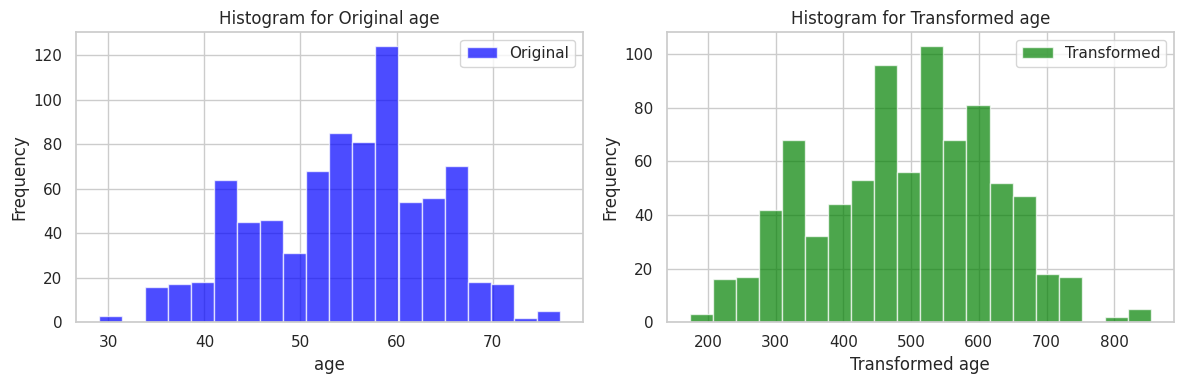

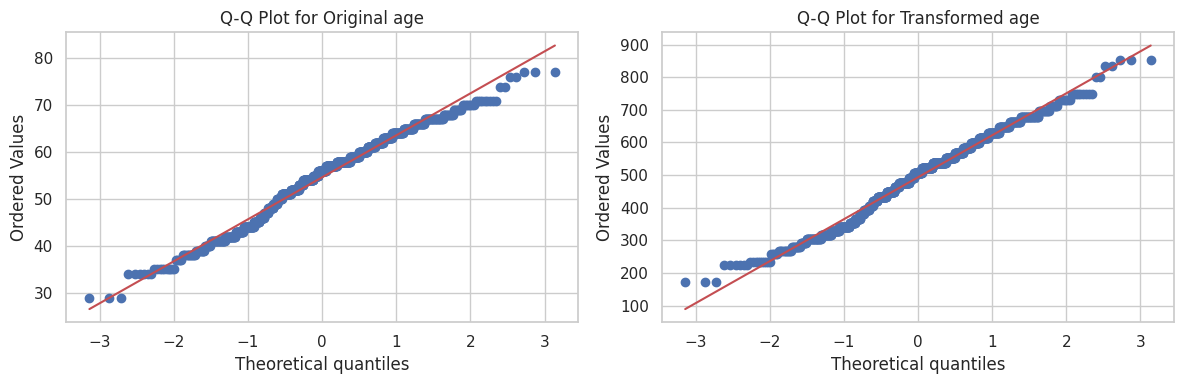

Shapiro-Wilk p-value for Transformed age: 3.6931603517587064e-06


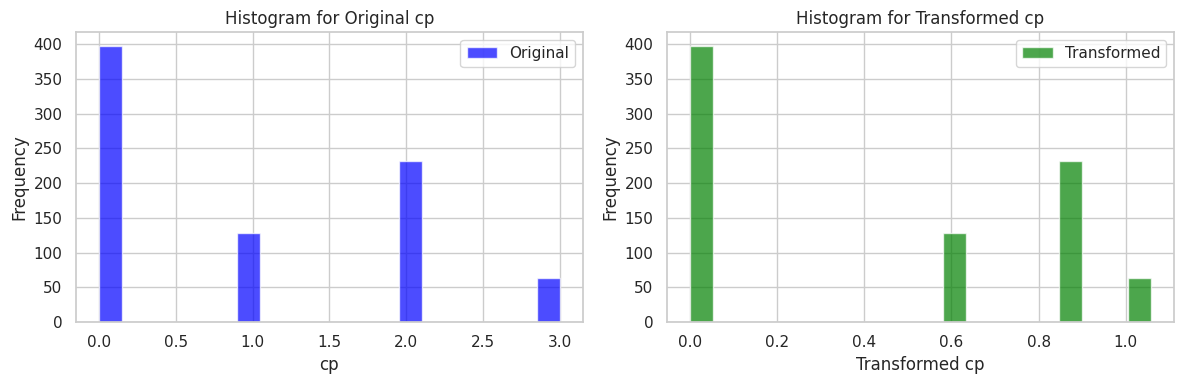

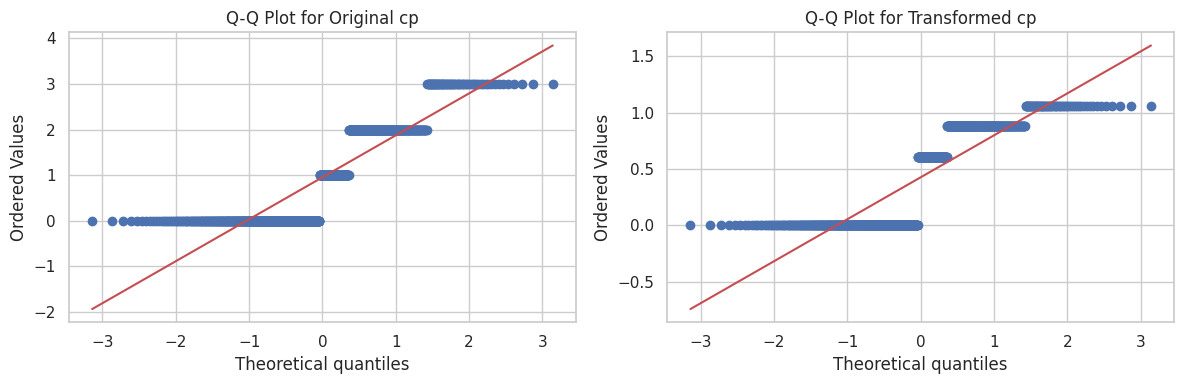

Shapiro-Wilk p-value for Transformed cp: 2.3637863453761757e-33


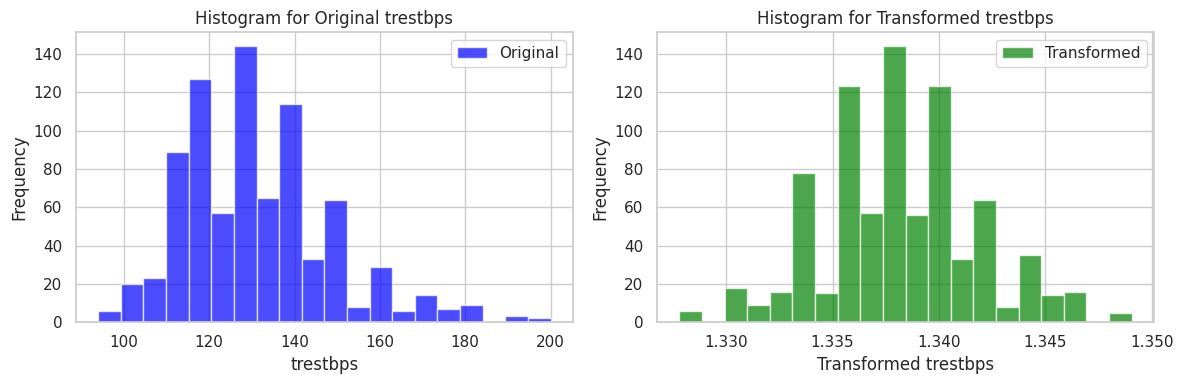

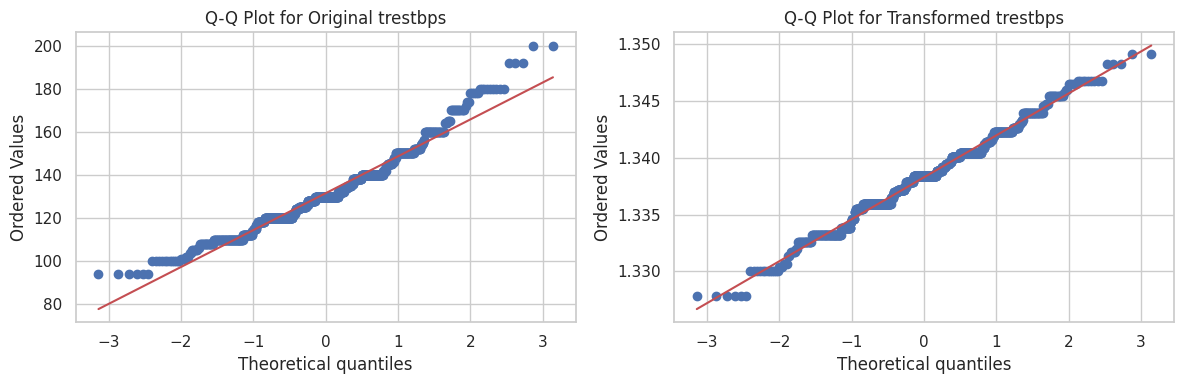

Shapiro-Wilk p-value for Transformed trestbps: 2.608519389468711e-05


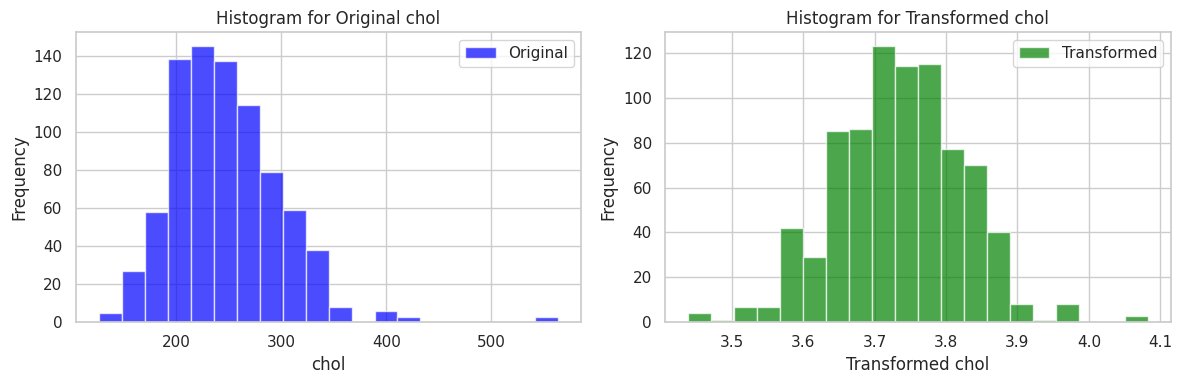

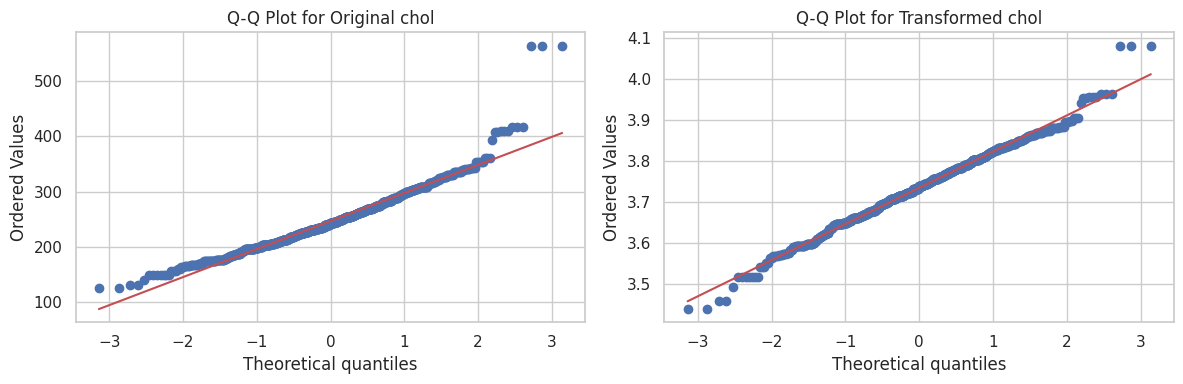

Shapiro-Wilk p-value for Transformed chol: 0.0005218642763793468


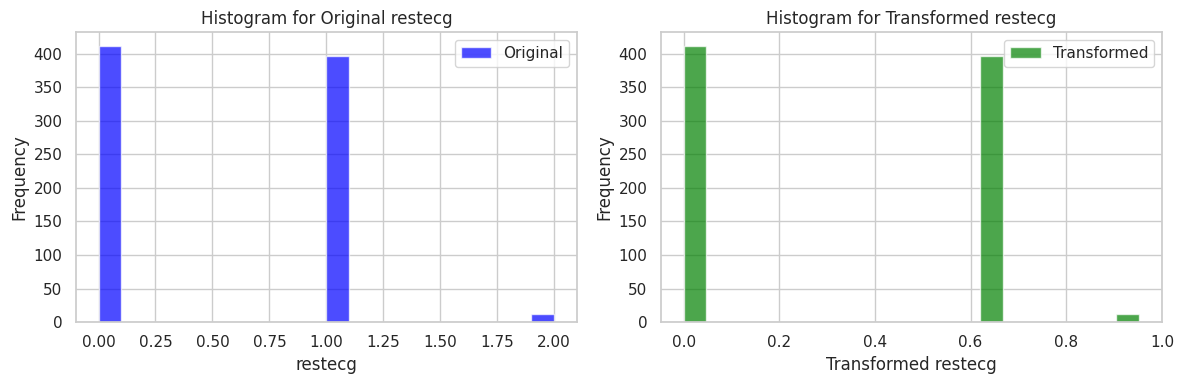

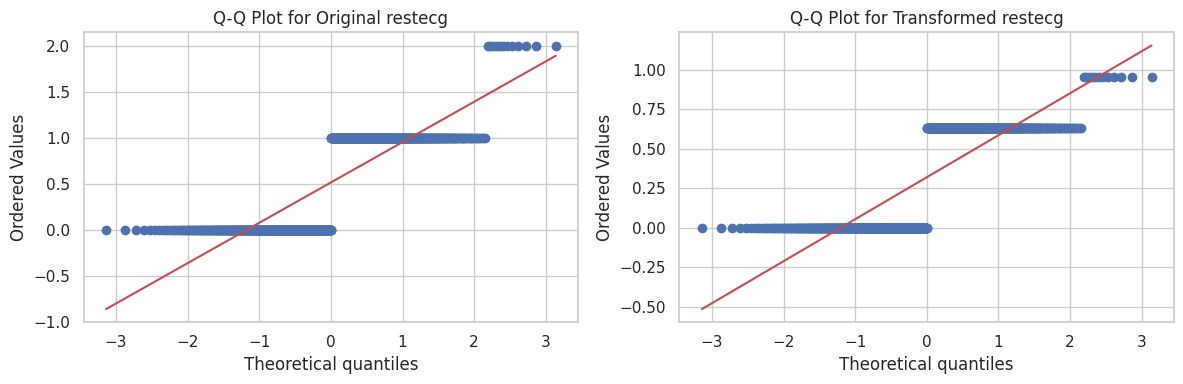

Shapiro-Wilk p-value for Transformed restecg: 3.7424942196774274e-37


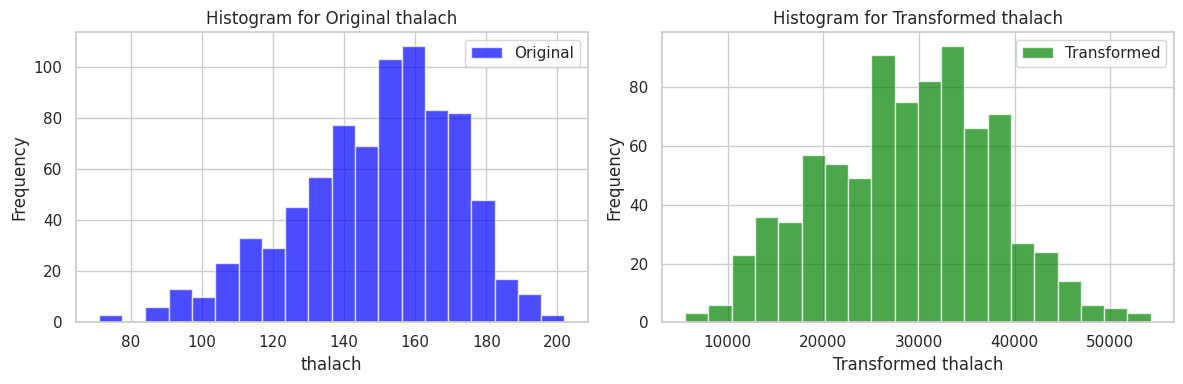

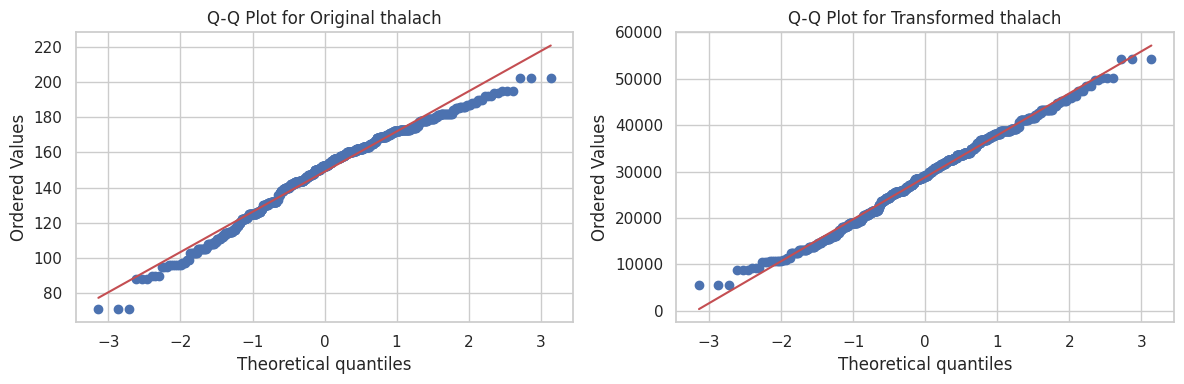

Shapiro-Wilk p-value for Transformed thalach: 0.000854808313306421


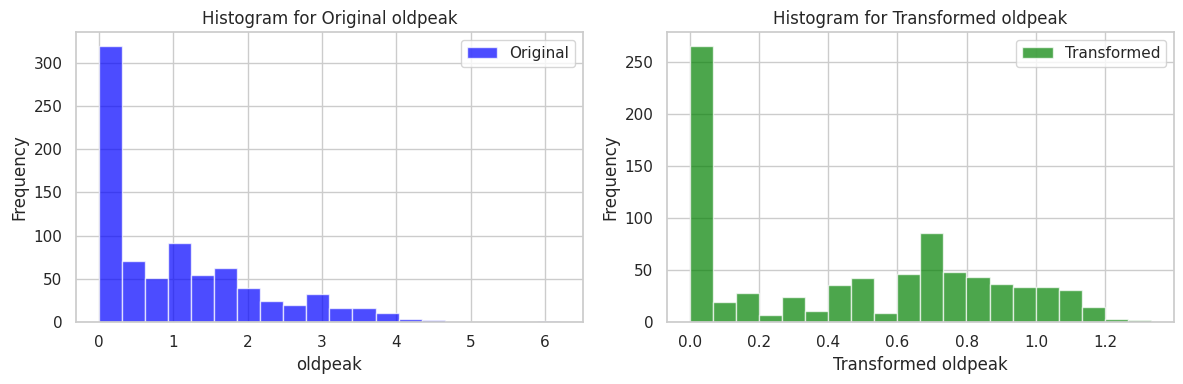

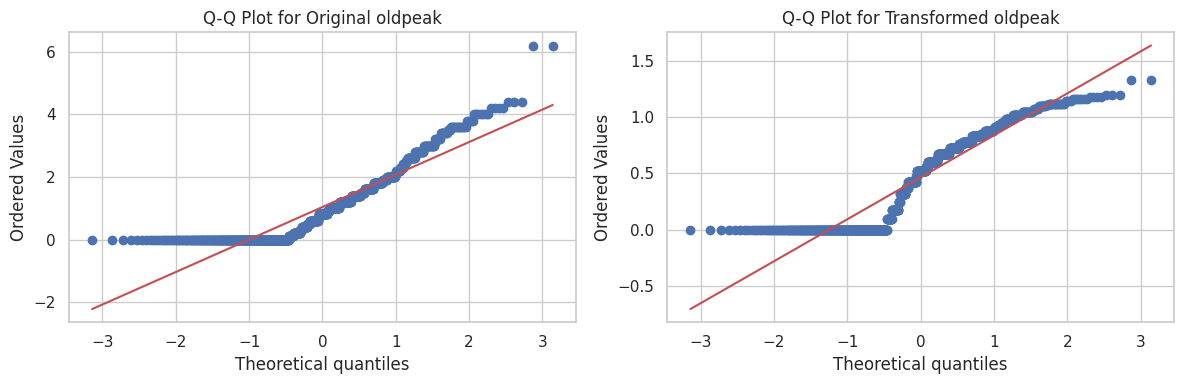

Shapiro-Wilk p-value for Transformed oldpeak: 1.2337431542401538e-24


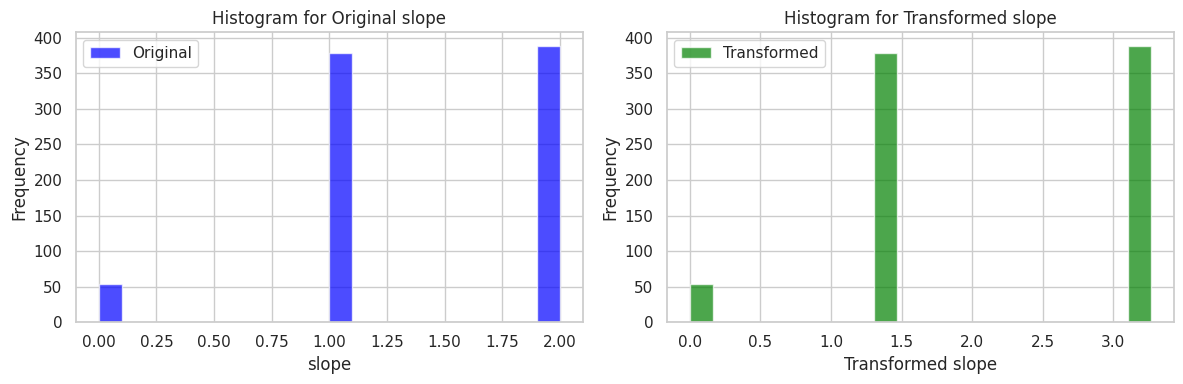

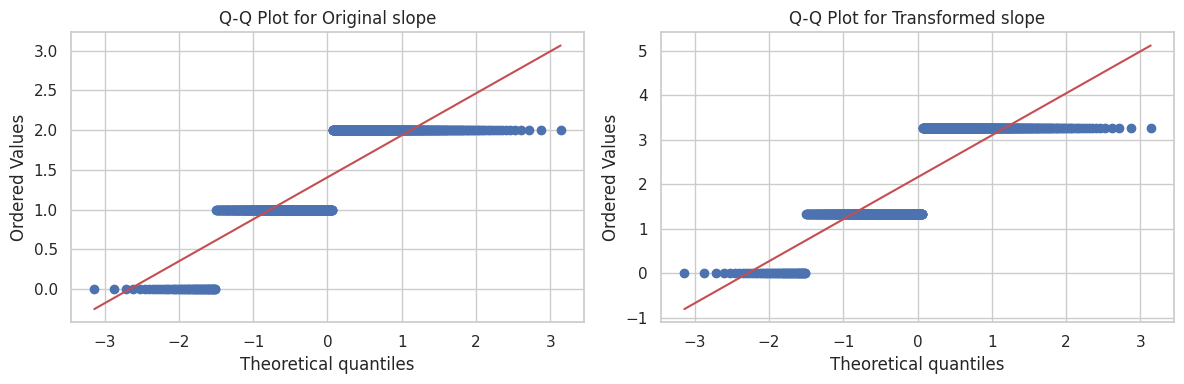

Shapiro-Wilk p-value for Transformed slope: 4.018608813390902e-34


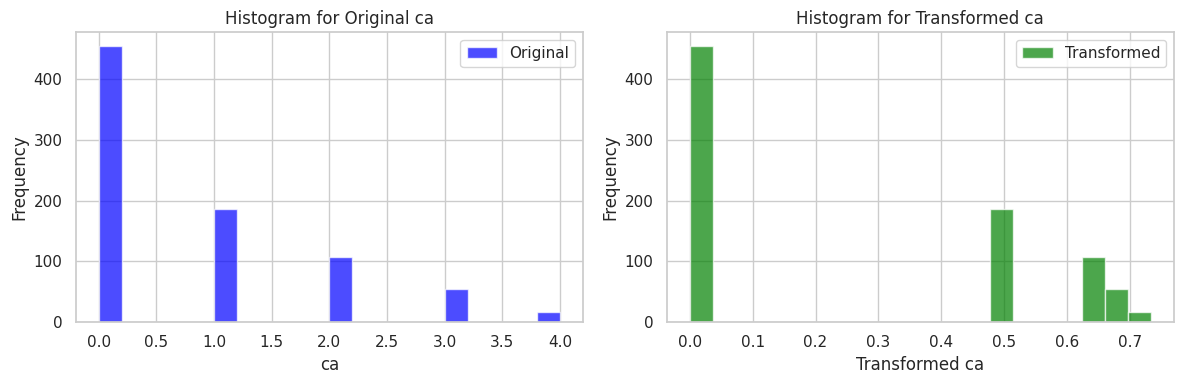

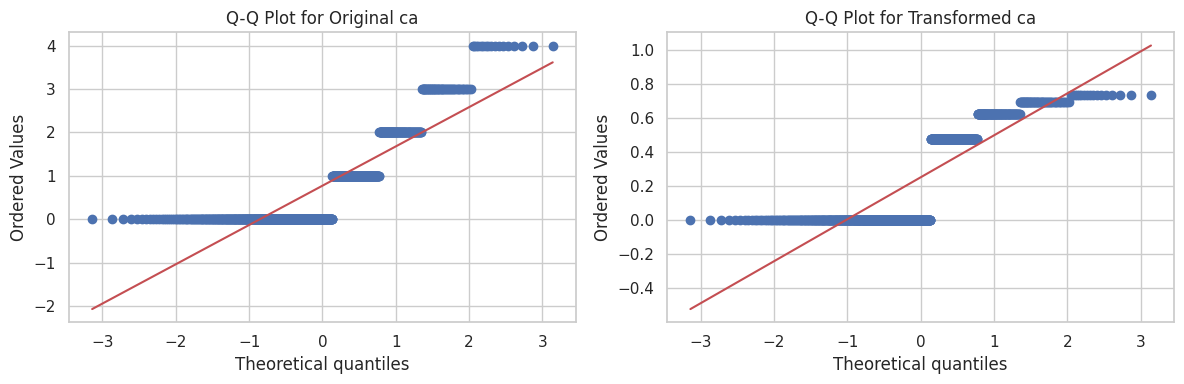

Shapiro-Wilk p-value for Transformed ca: 1.3210649768753531e-34


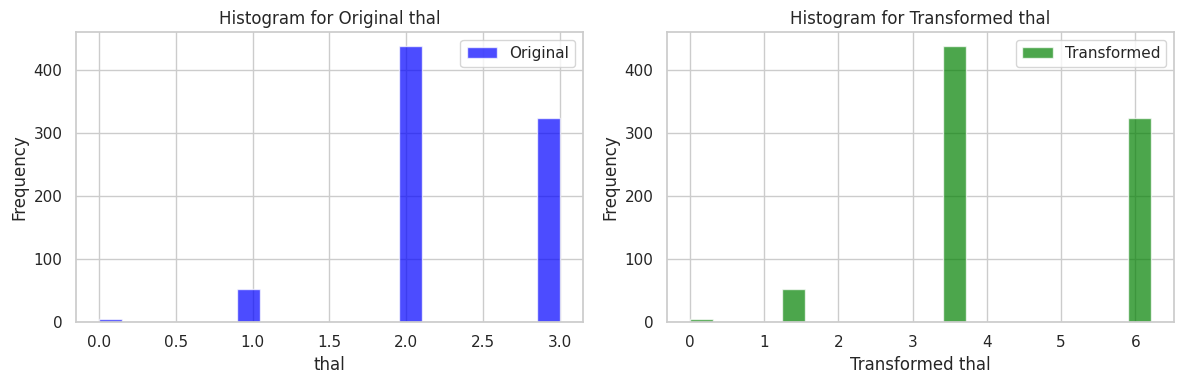

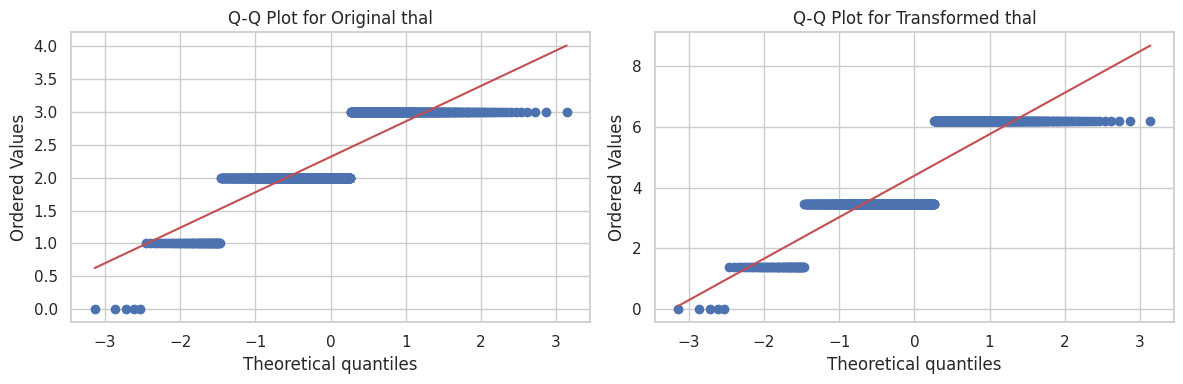

Shapiro-Wilk p-value for Transformed thal: 2.869052204596989e-33
   Original_age  Transformed_age  Original_cp  Transformed_cp  \
0            42       316.177959            3        1.057663   
1            66       662.818263            2        0.884643   
2            53       462.464730            2        0.884643   
3            58       536.114292            0        0.000000   
4            53       462.464730            0        0.000000   

   Original_trestbps  Transformed_trestbps  Original_chol  Transformed_chol  \
0                148              1.341919            244          3.739908   
1                146              1.341559            278          3.796094   
2                130              1.338341            246          3.743455   
3                100              1.330008            248          3.746970   
4                123              1.336710            282          3.802182   

   Original_restecg  Transformed_restecg  Original_thalach  \
0      

In [11]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the variables that may benefit from transformation
variables_to_transform = [
    'age',
    'cp',
    'trestbps',
    'chol',
    'restecg',
    'thalach',
    'oldpeak',
    'slope',
    'ca',
    'thal'
]

# Create a DataFrame to store the original and transformed data
comparison_df = pd.DataFrame()

# Perform and visualize transformations for each variable
for variable in variables_to_transform:
    original_data = df_engineering[variable]
    
    # Apply Box-Cox transformation
    transformed_data, lambda_value = stats.boxcox(original_data + 1)  # Adding 1 to handle zero values
    
    # Store original and transformed data in the comparison DataFrame
    comparison_df[f'Original_{variable}'] = original_data
    comparison_df[f'Transformed_{variable}'] = transformed_data
    
    # Plot histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(original_data, bins=20, color='blue', alpha=0.7, label='Original')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Histogram for Original {variable}')
    
    plt.subplot(1, 2, 2)
    plt.hist(transformed_data, bins=20, color='green', alpha=0.7, label='Transformed')
    plt.xlabel(f'Transformed {variable}')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Histogram for Transformed {variable}')
    
    plt.tight_layout()
    plt.show()
    
    # Plot Q-Q plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    stats.probplot(original_data, dist='norm', plot=plt)
    plt.title(f'Q-Q Plot for Original {variable}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(transformed_data, dist='norm', plot=plt)
    plt.title(f'Q-Q Plot for Transformed {variable}')
    
    plt.tight_layout()
    plt.show()
    
    # Perform Shapiro-Wilk test on transformed data
    statistic, p_value = stats.shapiro(transformed_data)
    print(f"Shapiro-Wilk p-value for Transformed {variable}: {p_value}")

# Display the first few rows of the comparison DataFrame
print(comparison_df.head())


We can see from the graphical and statistical observations above that transformations improved the distribution of data, but not necessarly his normality.

Developer will keep the transformations and decide based on the model performance next steps.

# SmartCorrelatedSelection Variables

In [12]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   42    1   3       148   244    0        0      178      0      0.8      2   
1   66    0   2       146   278    0        0      152      0      0.0      1   
2   53    1   2       130   246    1        0      173      0      0.0      2   

   ca  thal  
0   2     2  
1   1     2  
2   3     2

In [13]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[]

In [14]:
corr_sel.features_to_drop_

[]

Based on smartcorrelated feature there are no features to drop.

---

# Conclusions

The list below shows the transformations needed for feature engineering.
- these stes pwill be addes to the ML Pipel
ne
Feature Engineering Transform
er- **Yeo-Johnson numerical transformer
- **i 'age','cp','trestbps','chol','restecg','thalach','oldpeak','slope','ca','tha, 'l''**'- **]
Smart Correlation ectionSe *ecNone found
- **Categorical encoding**: Not requit']